In [1]:
import numpy.random as npr

import jax
import jax.numpy as jnp 
import jax.random as jrnd
from jaxutils import Dataset

import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# Imports from our code base
from active_search import get_next_y, get_next_candidate_baseline, get_next_candidate, compute_distances
from plotting import plot_candidate, plot_eig
from gp_model import update_model
from search_no_gpjax import generate_true_function, sample_from_posterior

/Users/dicai/miniconda3/envs/apm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set up the problem

In [3]:
seed = 2 # seed to use for all expts
num_iters = 14 # number of iterations to run
knot_N = 70 # number of points to discretize space into

# grid to discretize design space into
knot_x = jnp.linspace(0, 1, knot_N)
design_space = knot_x[:, jnp.newaxis]

npr.seed(seed); rng_key = jrnd.PRNGKey(seed)

# generate true data and envelope
true_y, true_envelope = generate_true_function(design_space, knot_N)

# Baseline: no convex hull information

Iteration:  0
CPU times: user 2.3 s, sys: 710 ms, total: 3.01 s
Wall time: 1.55 s
Iteration:  1
CPU times: user 2.23 s, sys: 549 ms, total: 2.78 s
Wall time: 1.37 s
Iteration:  2
CPU times: user 2.35 s, sys: 418 ms, total: 2.77 s
Wall time: 1.33 s
Iteration:  3
CPU times: user 2.35 s, sys: 422 ms, total: 2.78 s
Wall time: 1.31 s
Iteration:  4
CPU times: user 2.26 s, sys: 585 ms, total: 2.84 s
Wall time: 1.35 s
Iteration:  5
CPU times: user 2.26 s, sys: 437 ms, total: 2.7 s
Wall time: 1.31 s
Iteration:  6
CPU times: user 2.14 s, sys: 503 ms, total: 2.65 s
Wall time: 1.28 s
Iteration:  7
CPU times: user 2.31 s, sys: 359 ms, total: 2.67 s
Wall time: 1.27 s
Iteration:  8
CPU times: user 2.24 s, sys: 243 ms, total: 2.48 s
Wall time: 1.23 s
Iteration:  9
CPU times: user 2.26 s, sys: 324 ms, total: 2.58 s
Wall time: 1.25 s
Iteration:  10
CPU times: user 2.16 s, sys: 354 ms, total: 2.51 s
Wall time: 1.18 s
Iteration:  11
CPU times: user 2.2 s, sys: 295 ms, total: 2.49 s
Wall time: 1.18 s
Itera

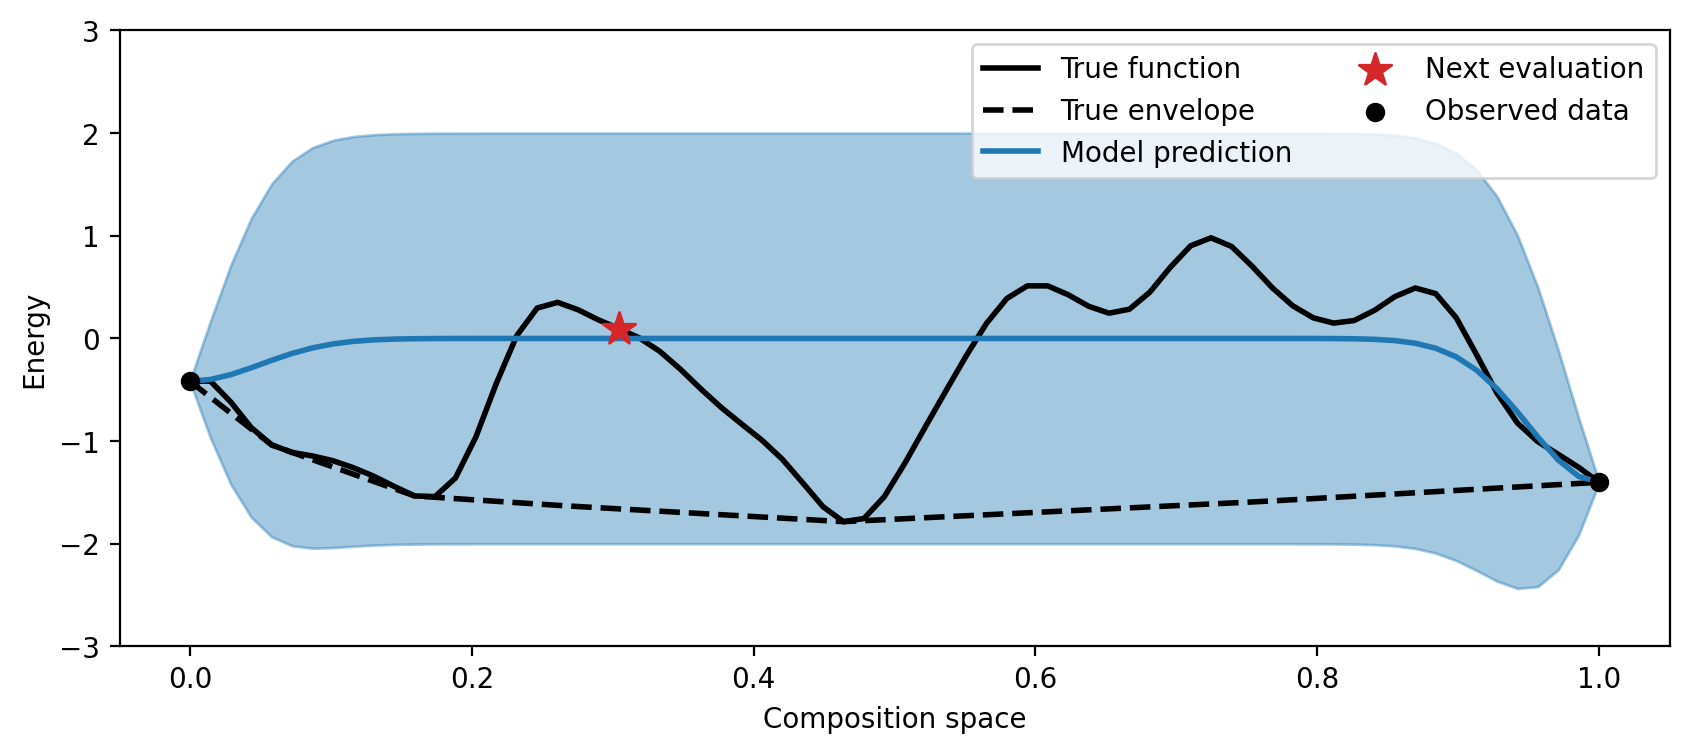

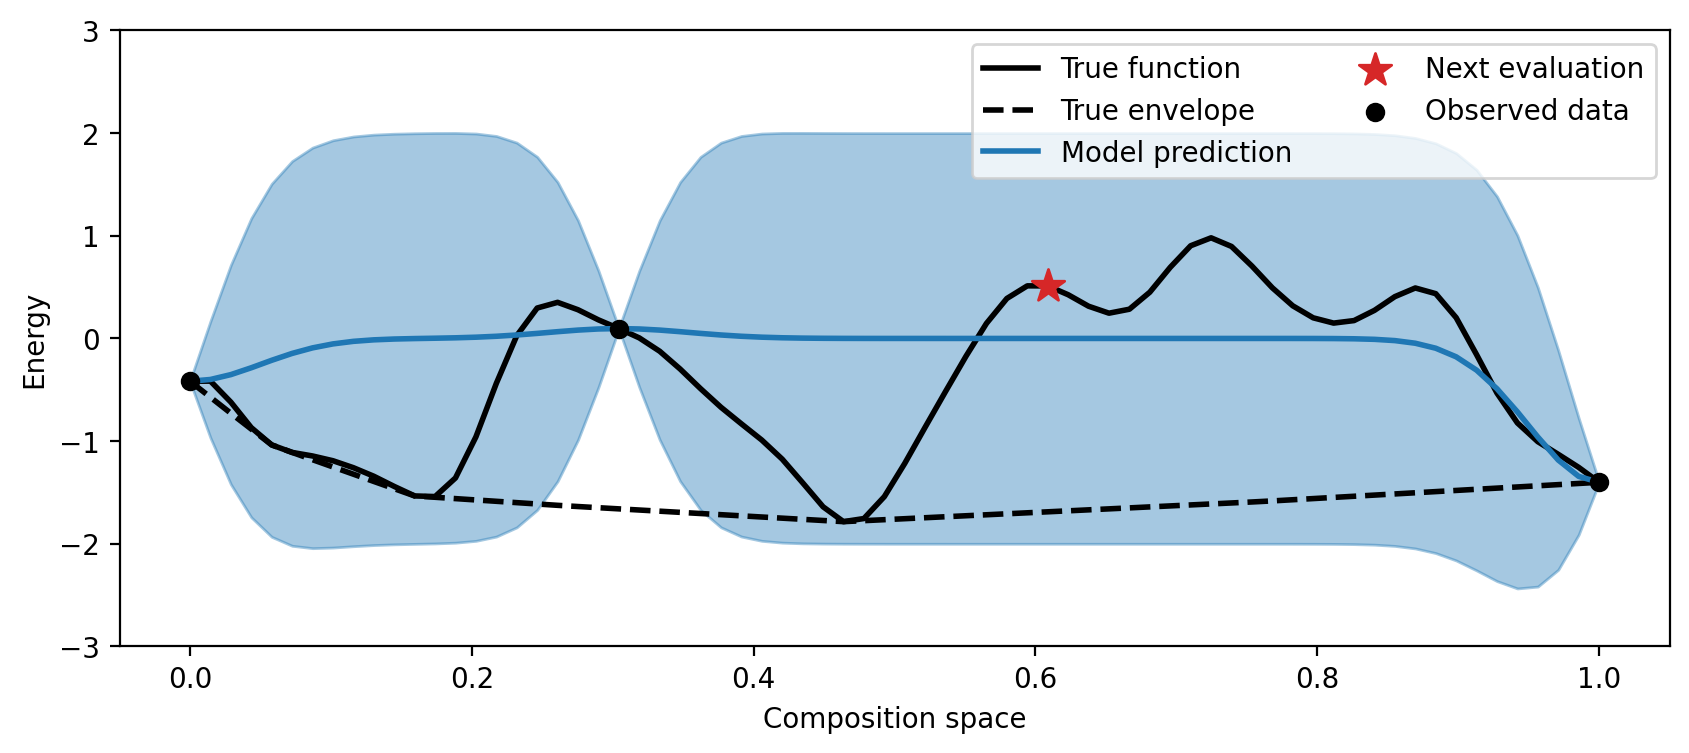

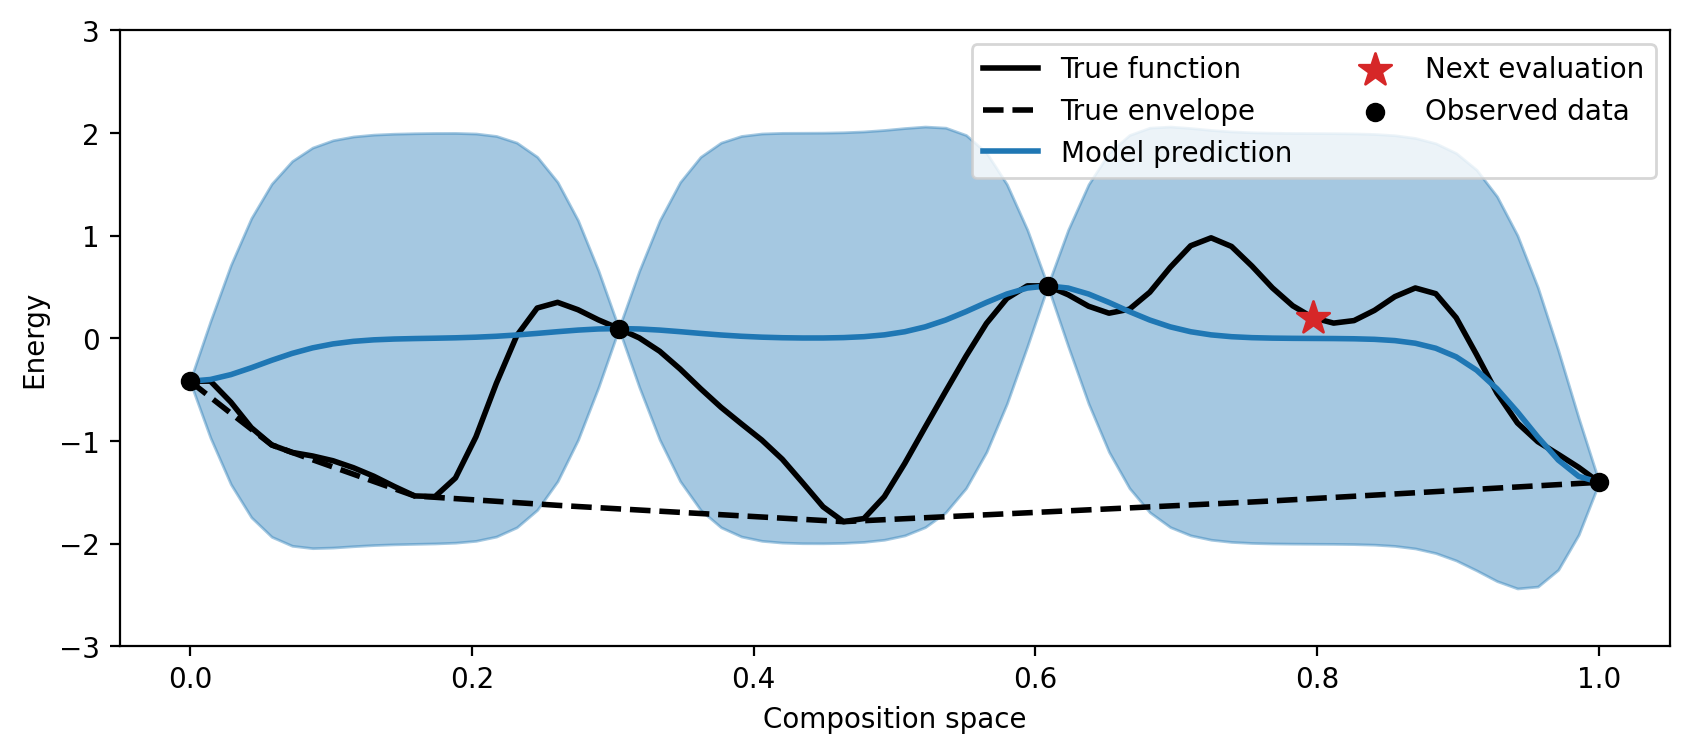

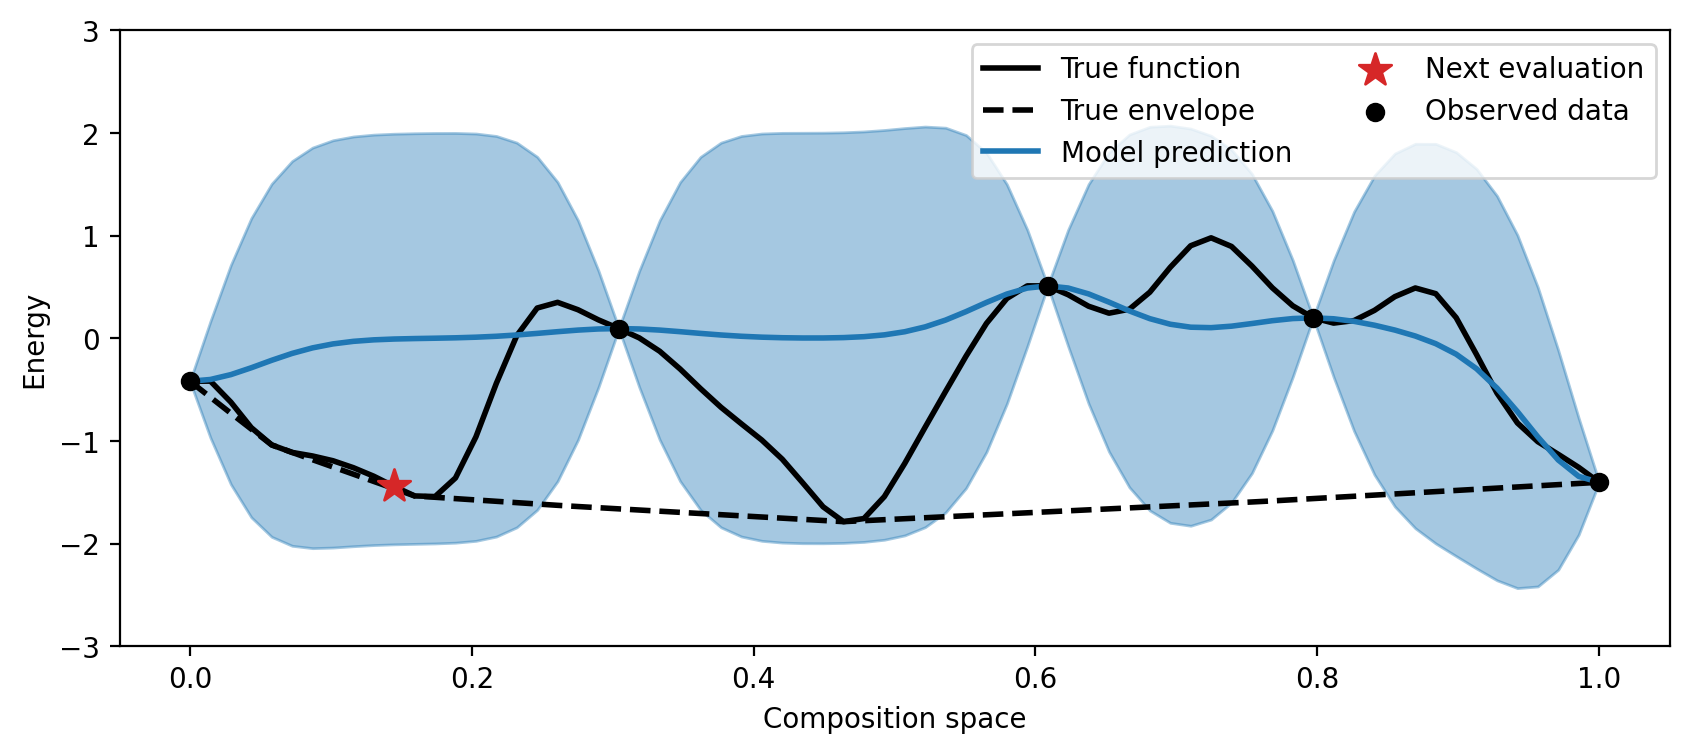

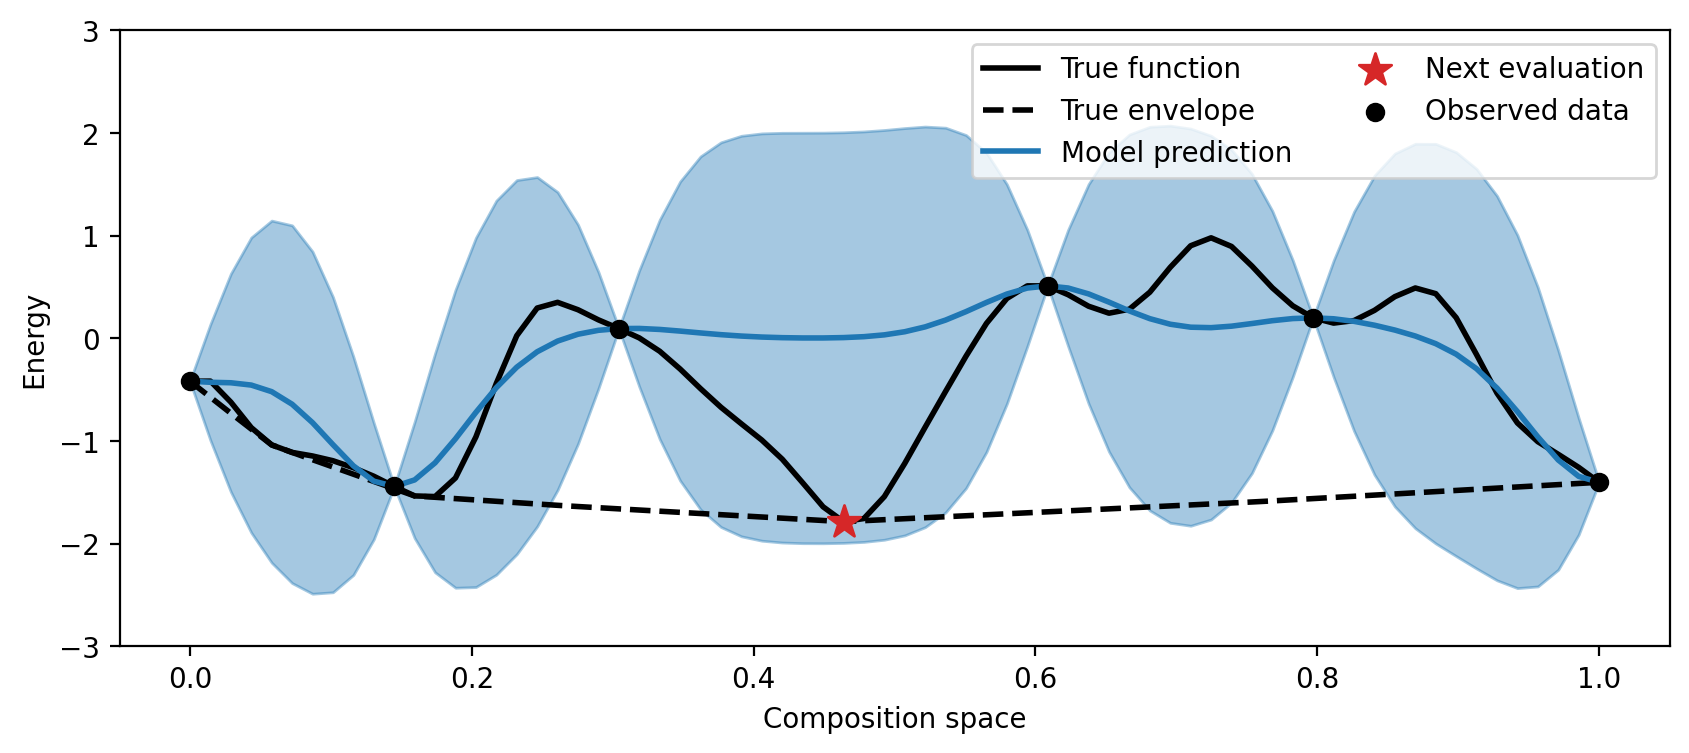

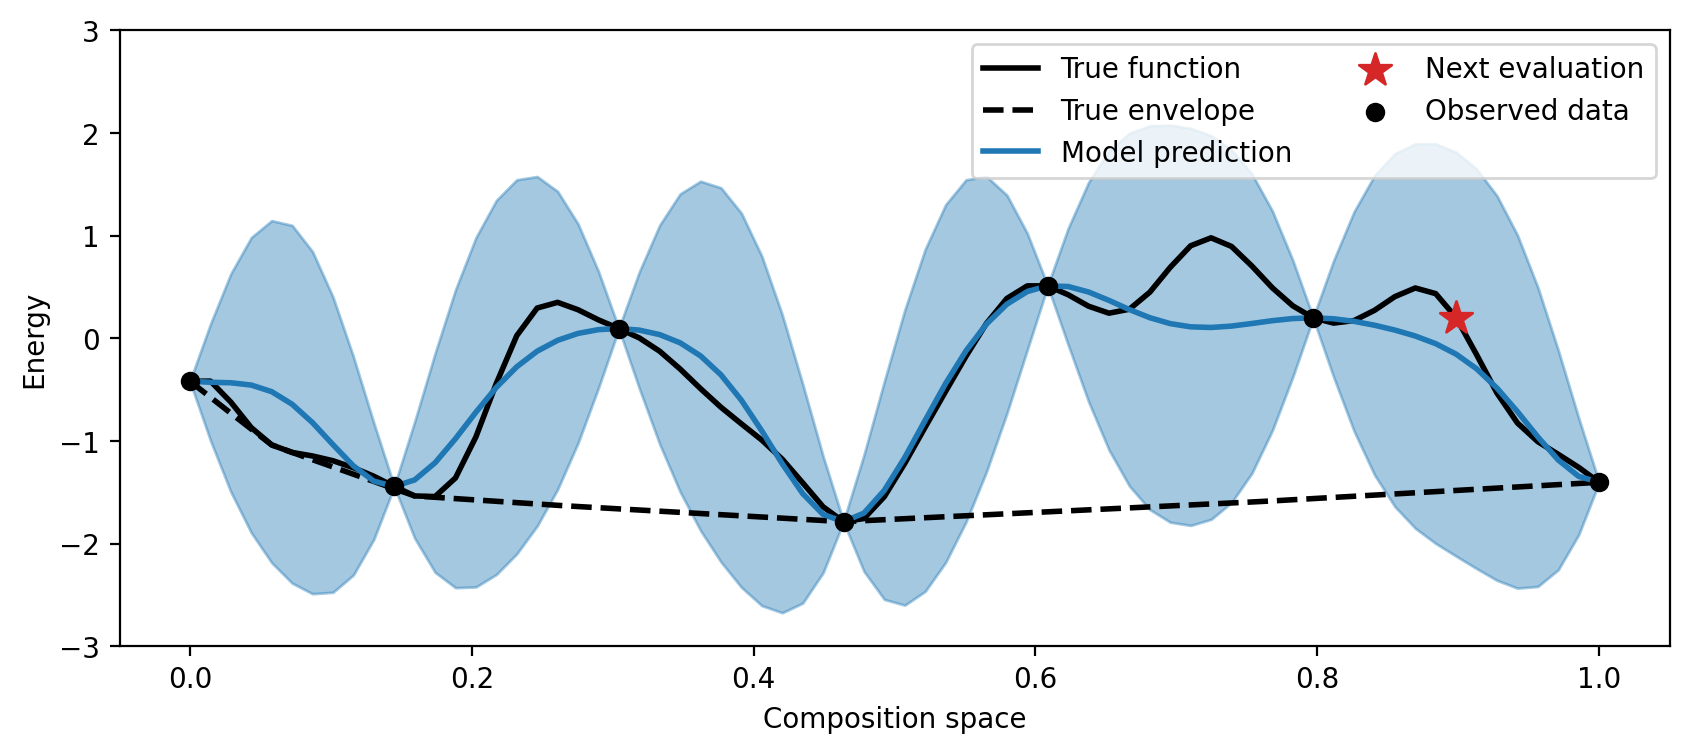

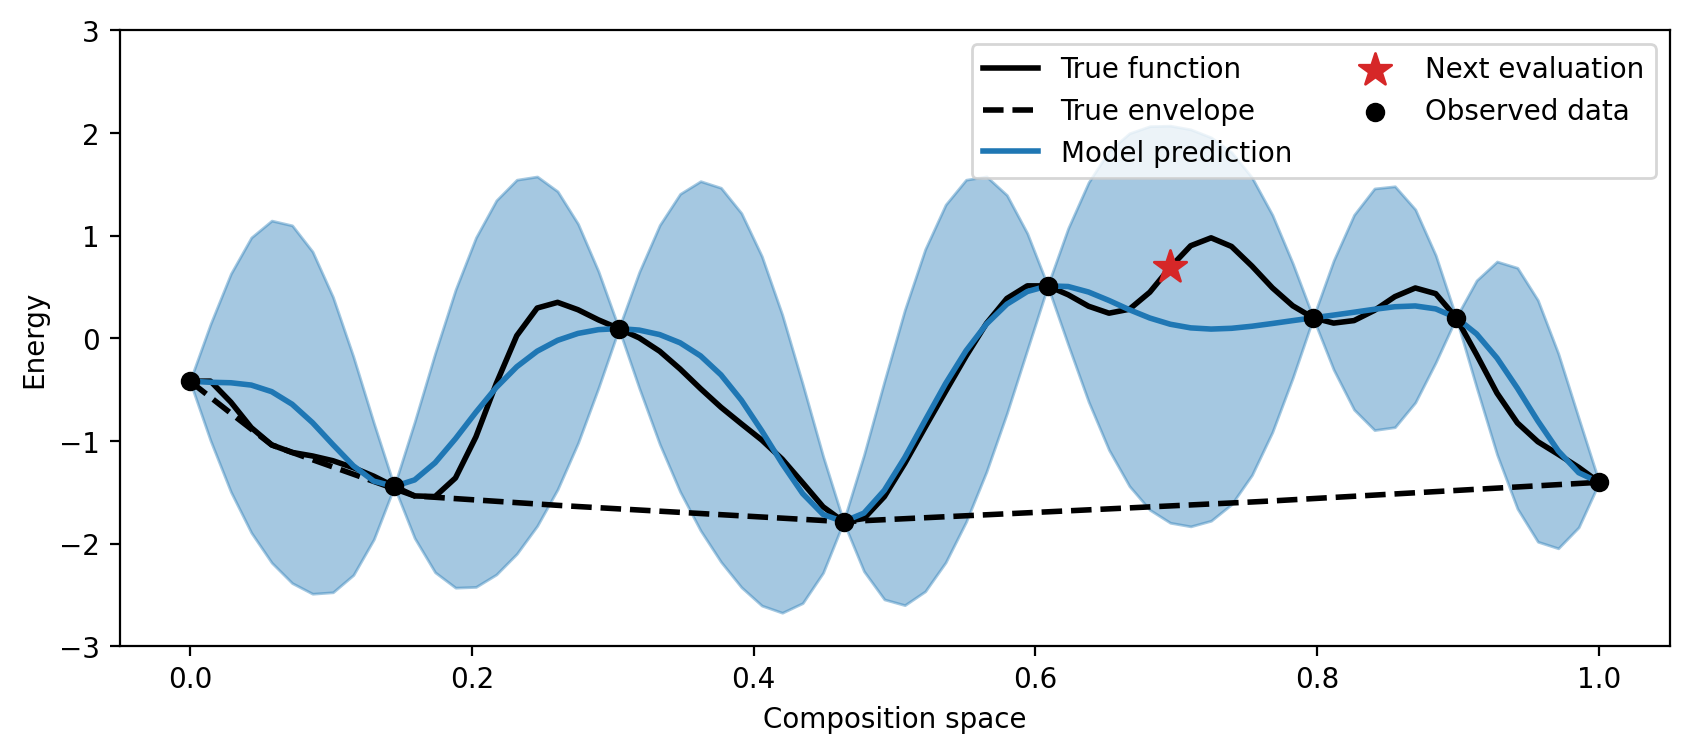

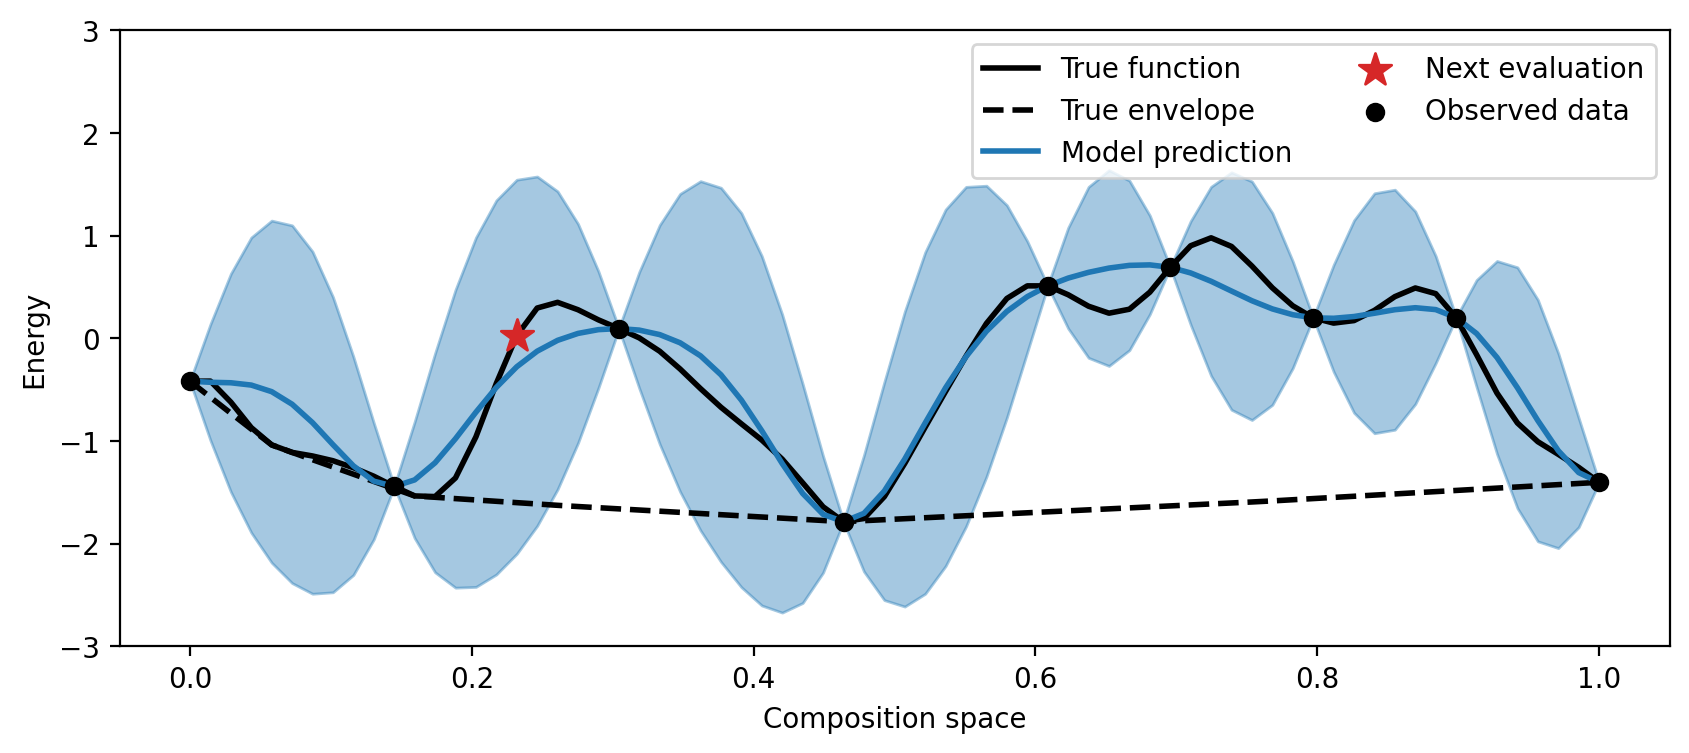

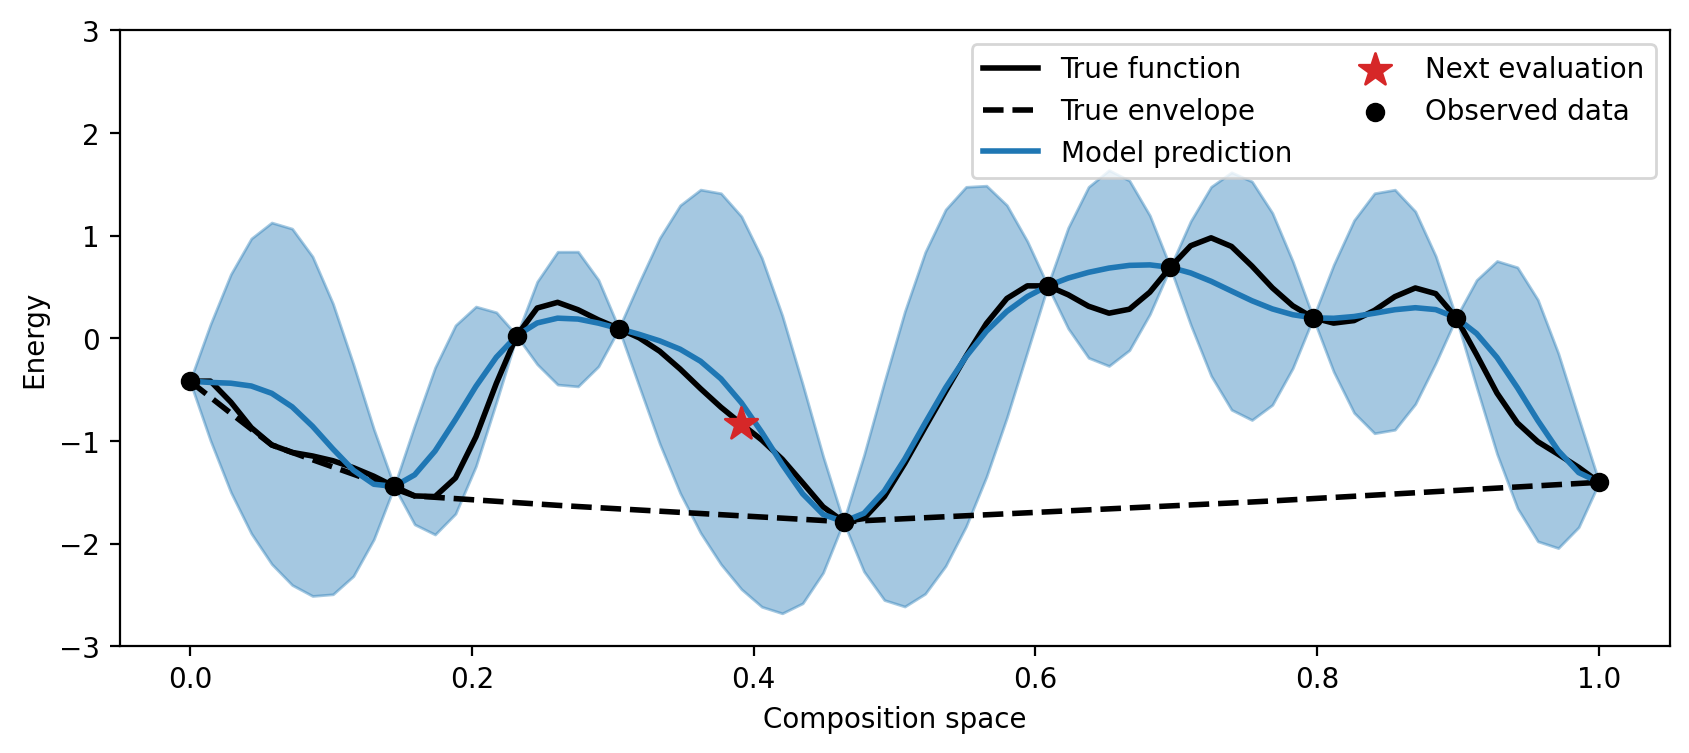

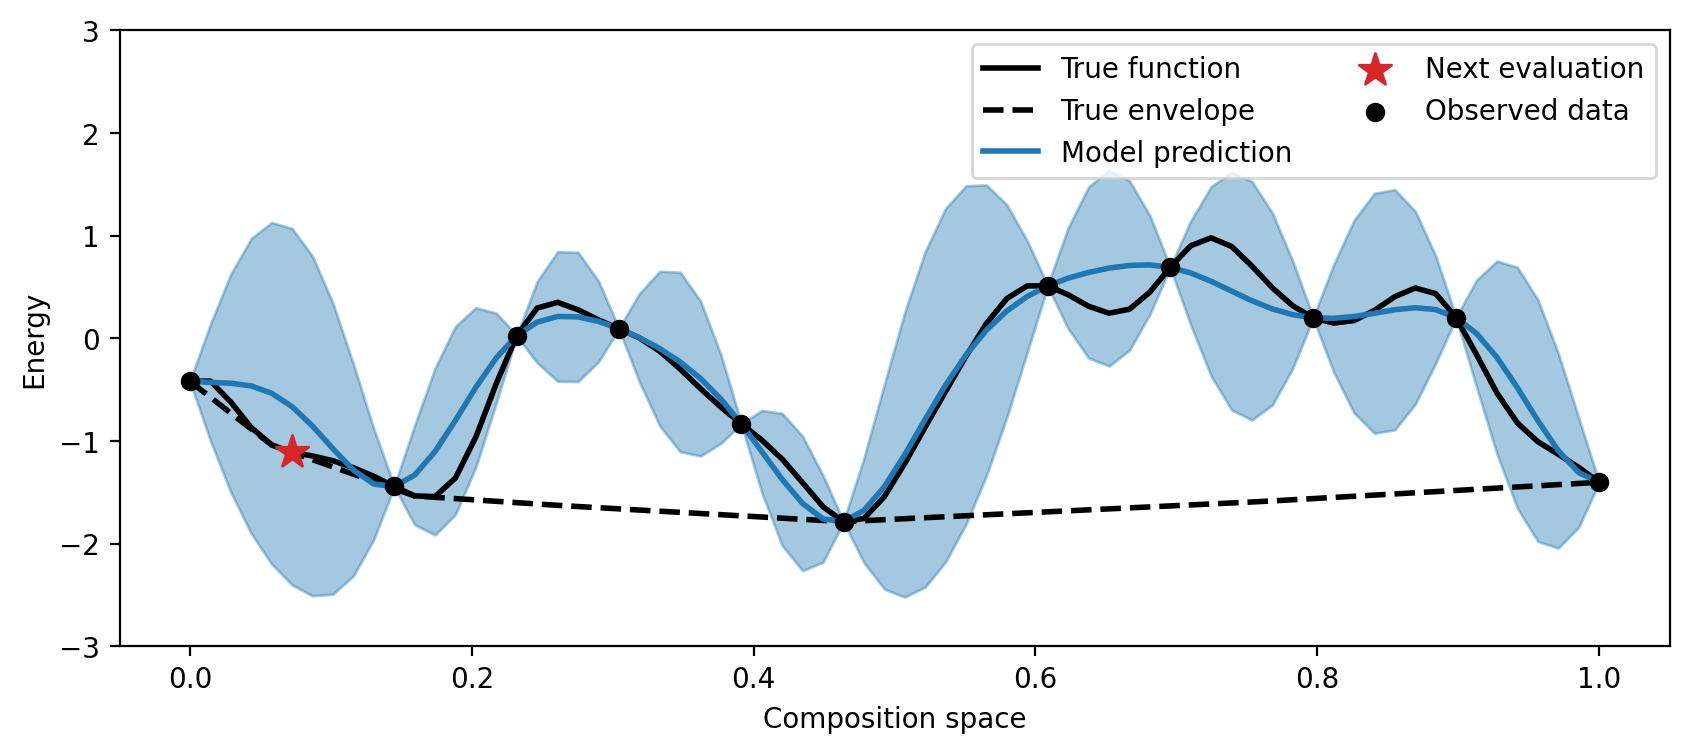

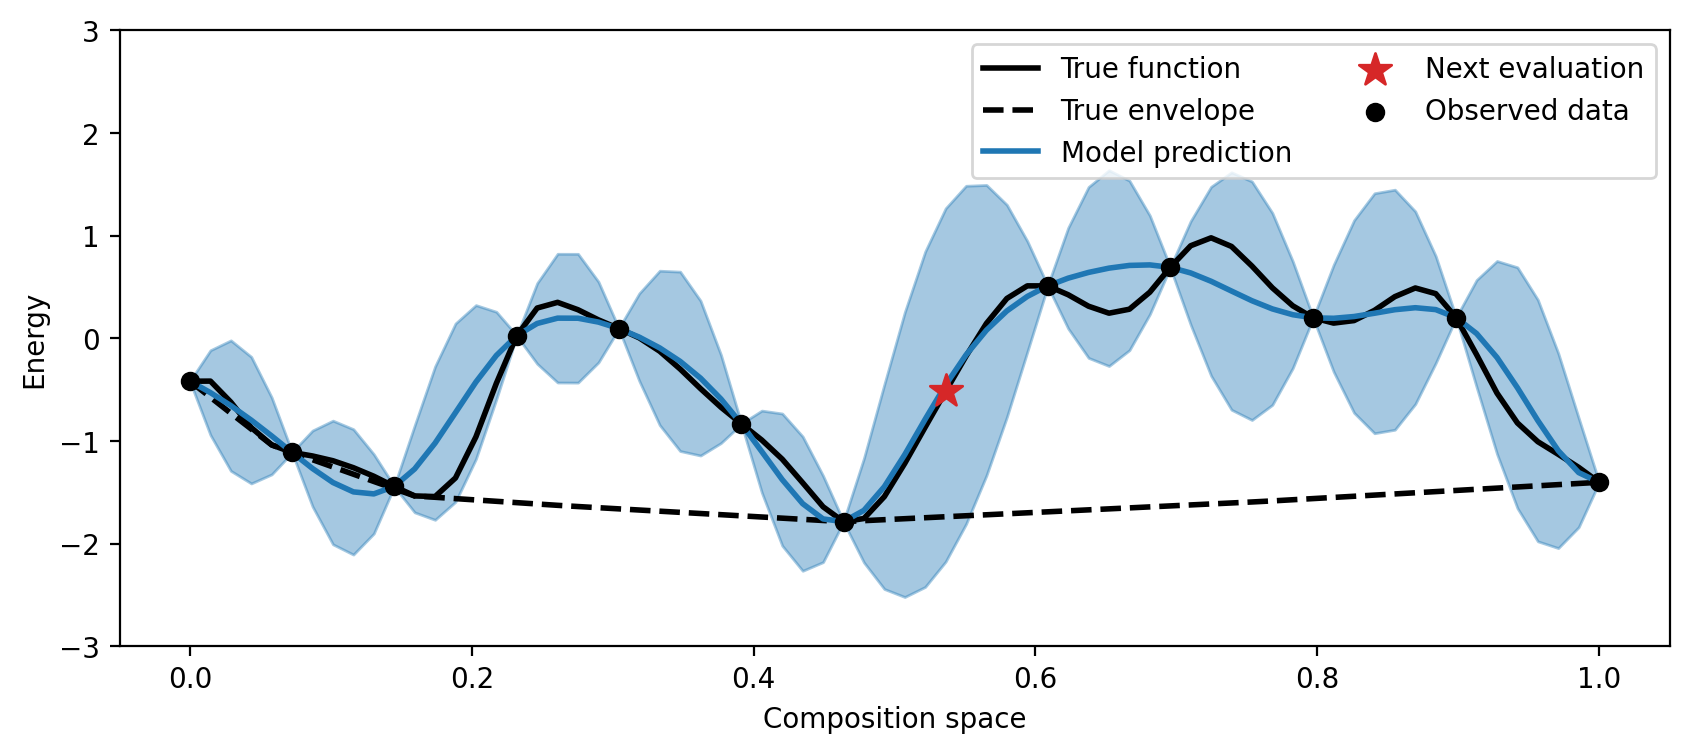

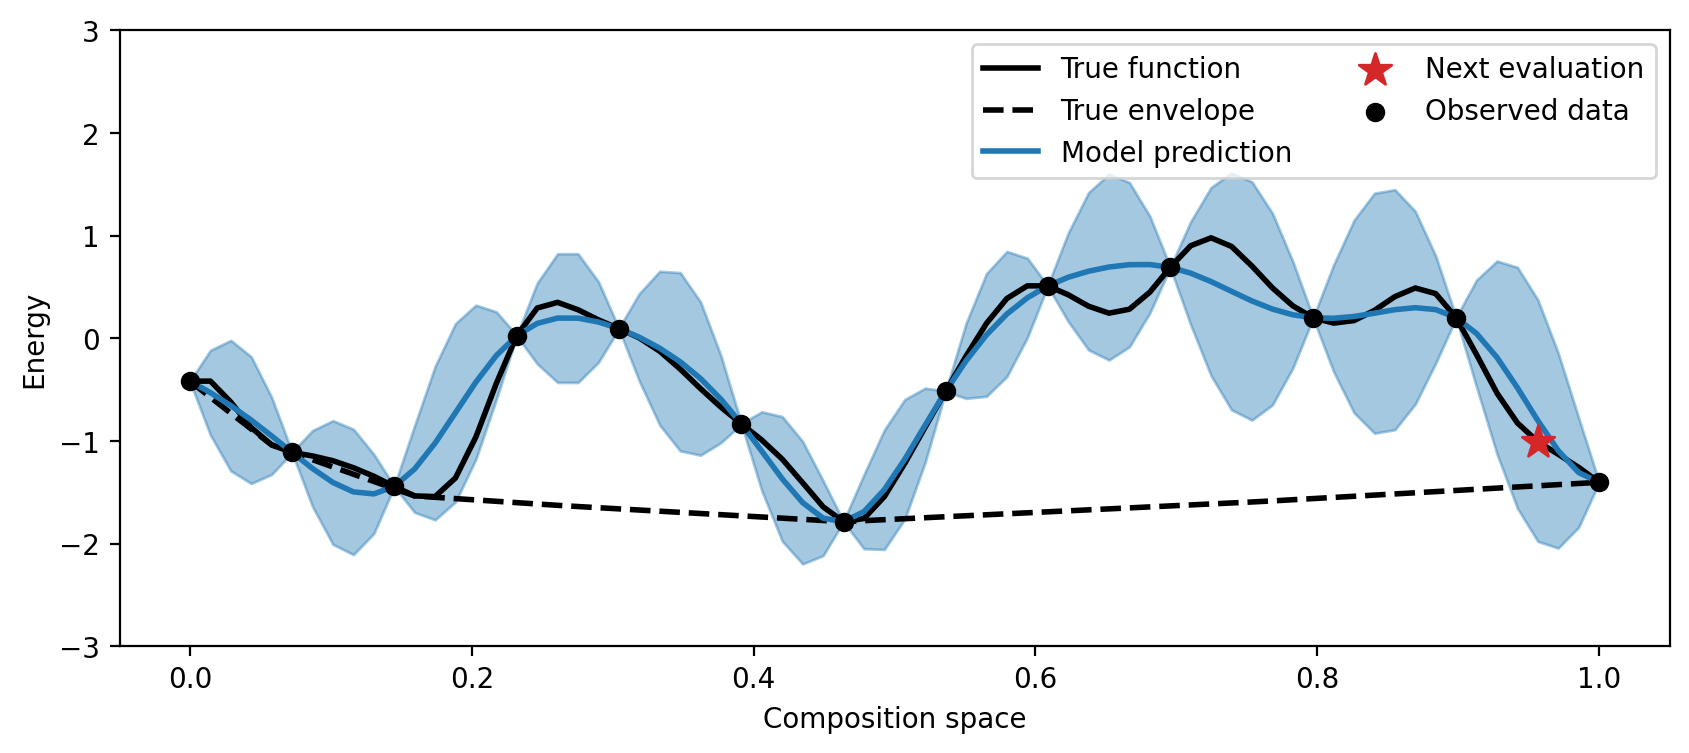

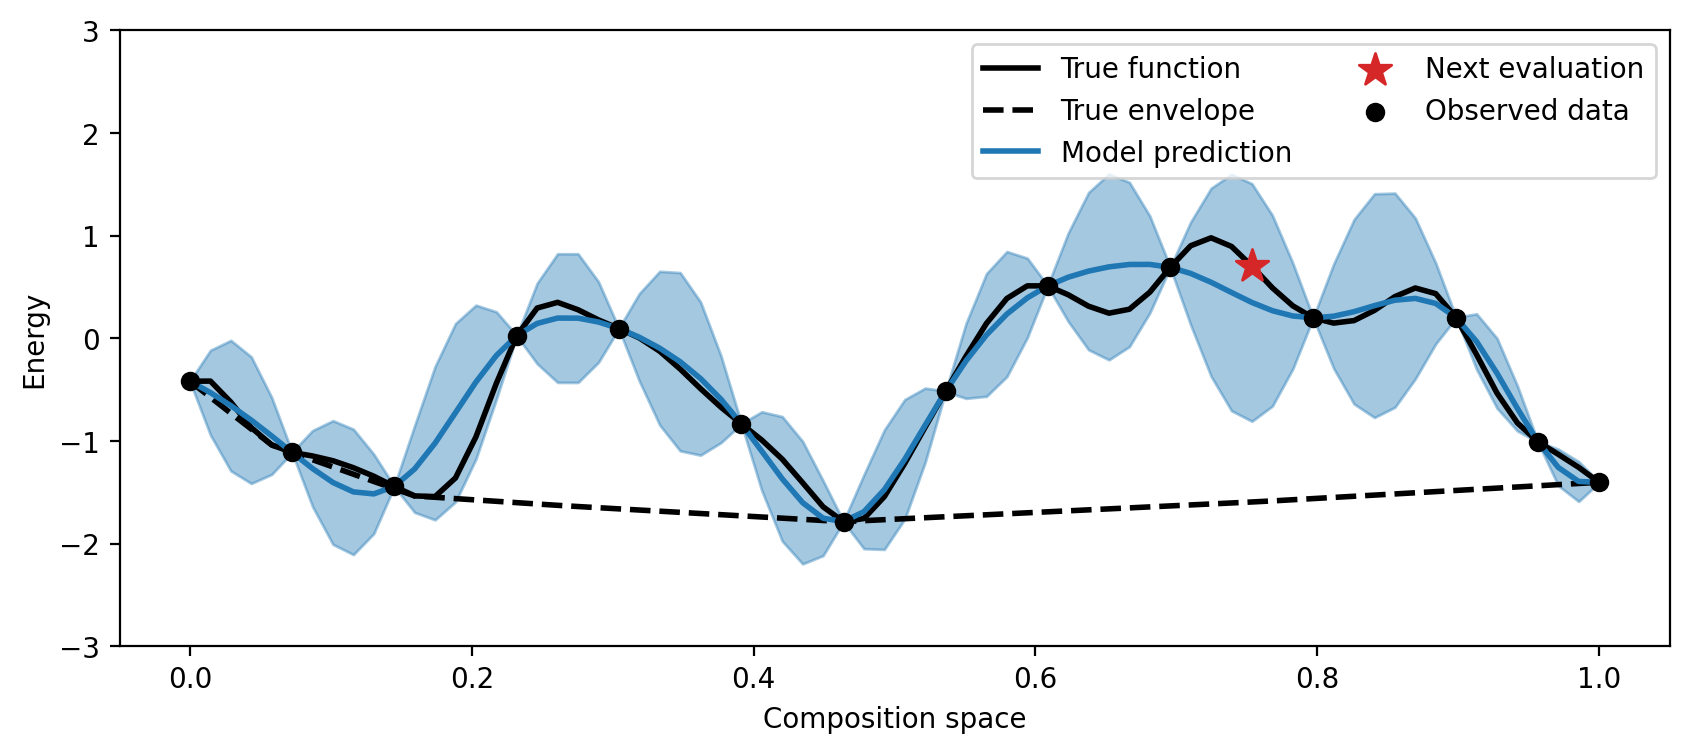

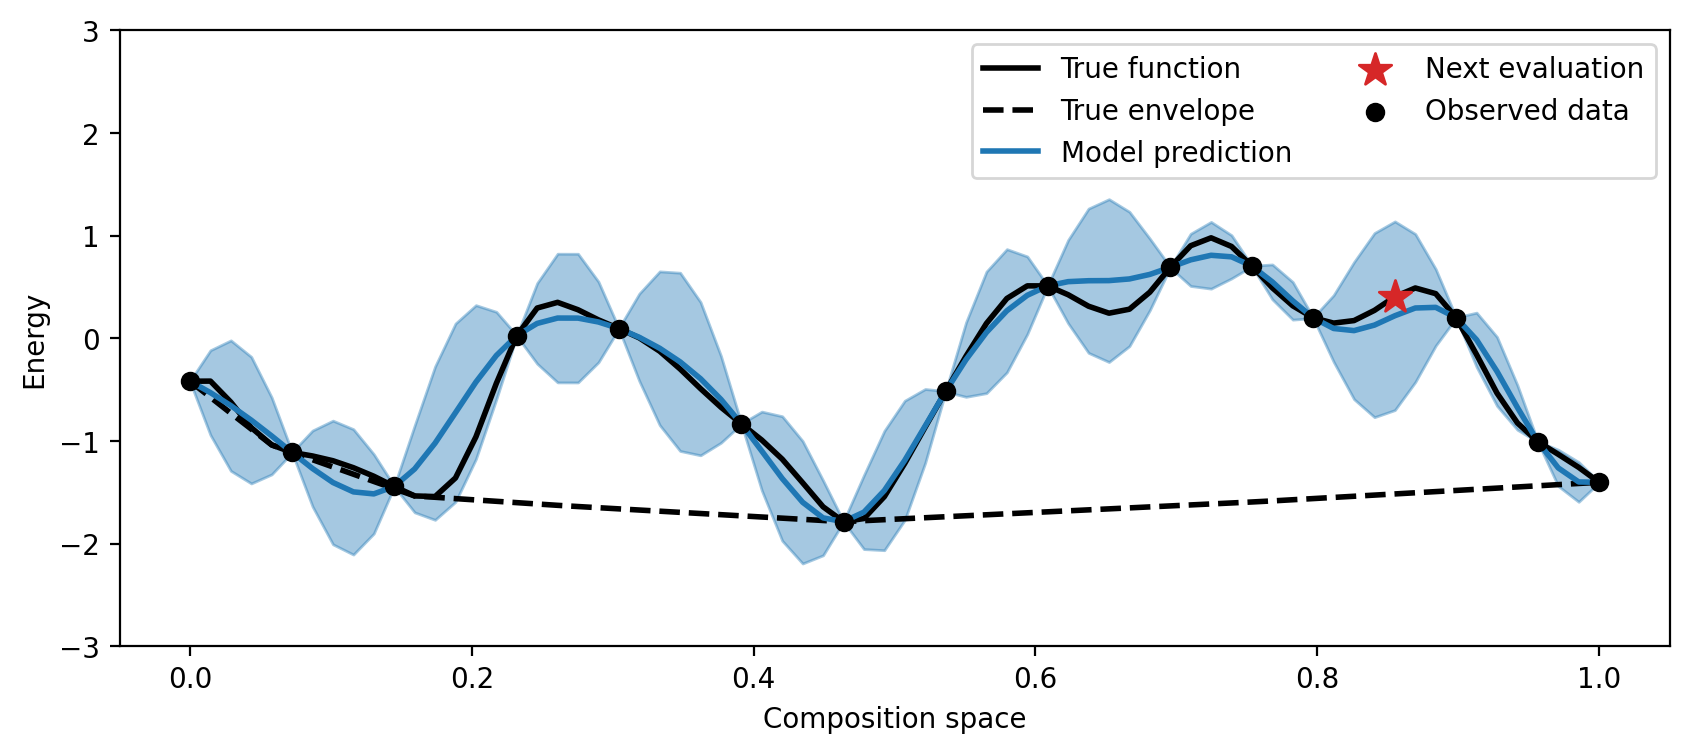

In [5]:
npr.seed(seed); rng_key = jrnd.PRNGKey(seed)

# Suppose we start out by observing the two end points
train_x = jnp.array([design_space[0], design_space[-1]]); train_y = jnp.array([true_y[0], true_y[-1]])
dataset = Dataset(X=train_x, y=train_y[:,jnp.newaxis])
designs = design_space[1:-1]

distances_baseline = []; distances_baseline.append(compute_distances(dataset, design_space, true_envelope))

# Update the model given the data above
pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)

for i in range(num_iters):
    print("Iteration: ", i)

    %time next_x, entropy_change = get_next_candidate_baseline(posterior, params, dataset, designs, design_space)
    #print(entropy_change)
    plot_candidate(knot_x, true_y, true_envelope, pred_mean, pred_cov, [], dataset, next_x, entropy_change, plot_eig=False, plot_hulls=False)
    
    # add observations to data and update model
    dataset = dataset + Dataset(X=jnp.atleast_2d(next_x), y=jnp.atleast_2d(get_next_y(true_y, design_space, next_x)))
    designs = jnp.delete(designs, (designs == next_x).argmax())[:, jnp.newaxis]
    pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)
    distances_baseline.append(compute_distances(dataset, design_space, true_envelope))

# Convex-hull-aware active search (CHAASe)

Iteration:  0
CPU times: user 49.9 s, sys: 5.23 s, total: 55.1 s
Wall time: 51 s
[0.97101449] [1.17082665 1.17452091 1.15405376 1.1438799  1.12818483 1.10708024
 1.09233311 1.07300197 1.04806259 1.01309316 0.9643401  0.92307573
 0.88699763 0.89060337 0.90112862 0.88935603 0.8587278  0.8448573
 0.87472207 0.93825447 0.97723534 0.96284282 0.93968507 0.91235859
 0.87037512 0.84293284 0.84795731 0.88577405 0.9318348  0.95185929
 0.95773573 0.96457777 0.9872202  1.00222055 1.01520964 1.01927625
 1.01603055 1.01555783 1.03485156 1.01528896 0.95372878 0.87236428
 0.8356783  0.86653127 0.90688037 0.9148473  0.91482587 0.92627291
 0.93517084 0.94219271 0.96048344 0.9611952  0.94822924 0.9376886
 0.92750652 0.91232621 0.90396169 0.90071362 0.89100771 0.90454977
 0.94651666 1.01819788 1.10074186 1.16954244 1.22340224 1.2451167
 1.2612402  1.20826287]
Iteration:  1
CPU times: user 48 s, sys: 5.31 s, total: 53.3 s
Wall time: 49.1 s
[0.01449275] [1.16324326 1.14145002 1.11184864 1.08157167 1.0630835

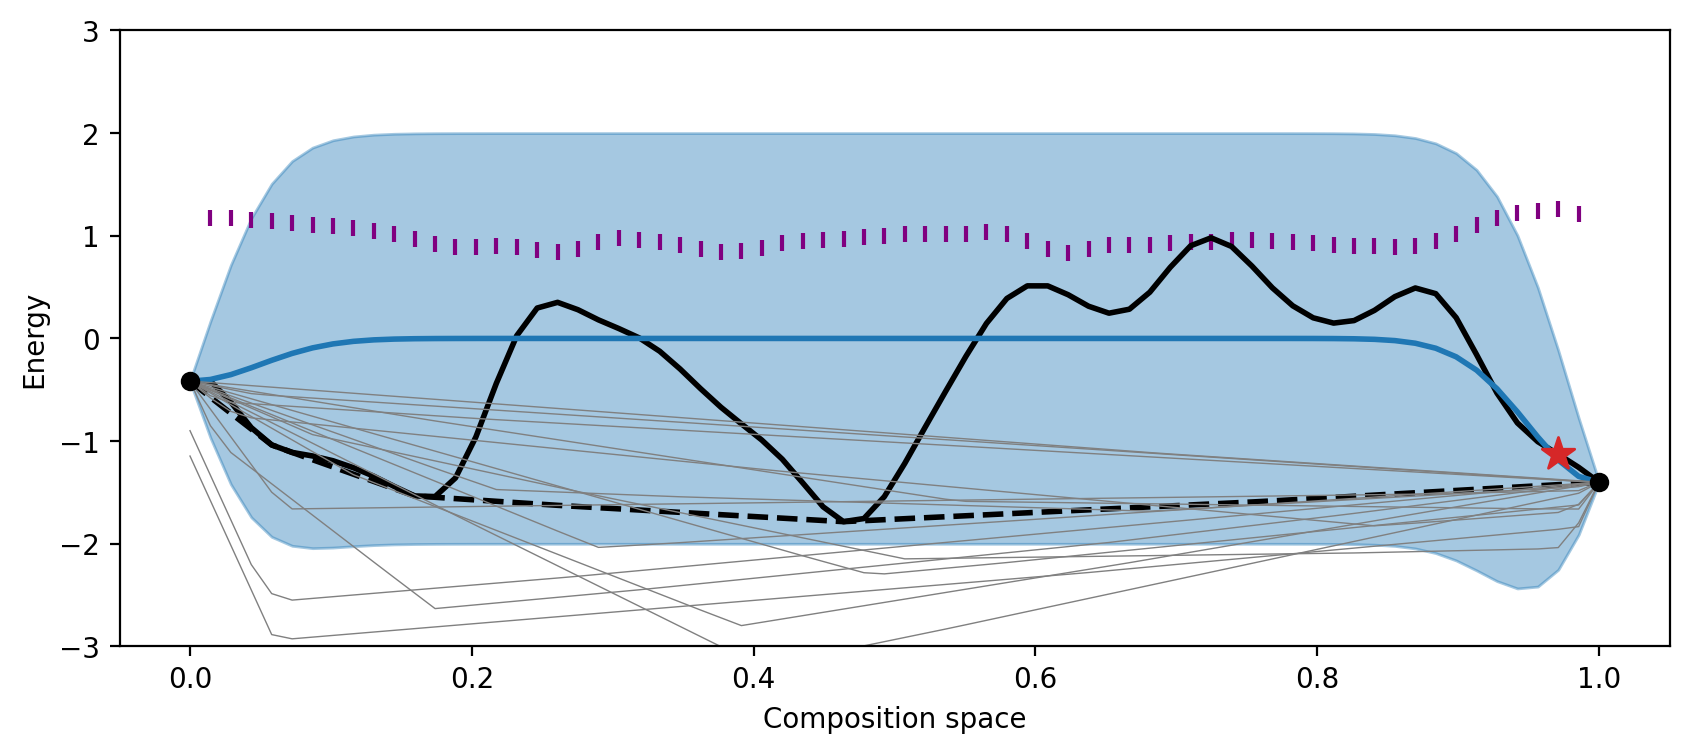

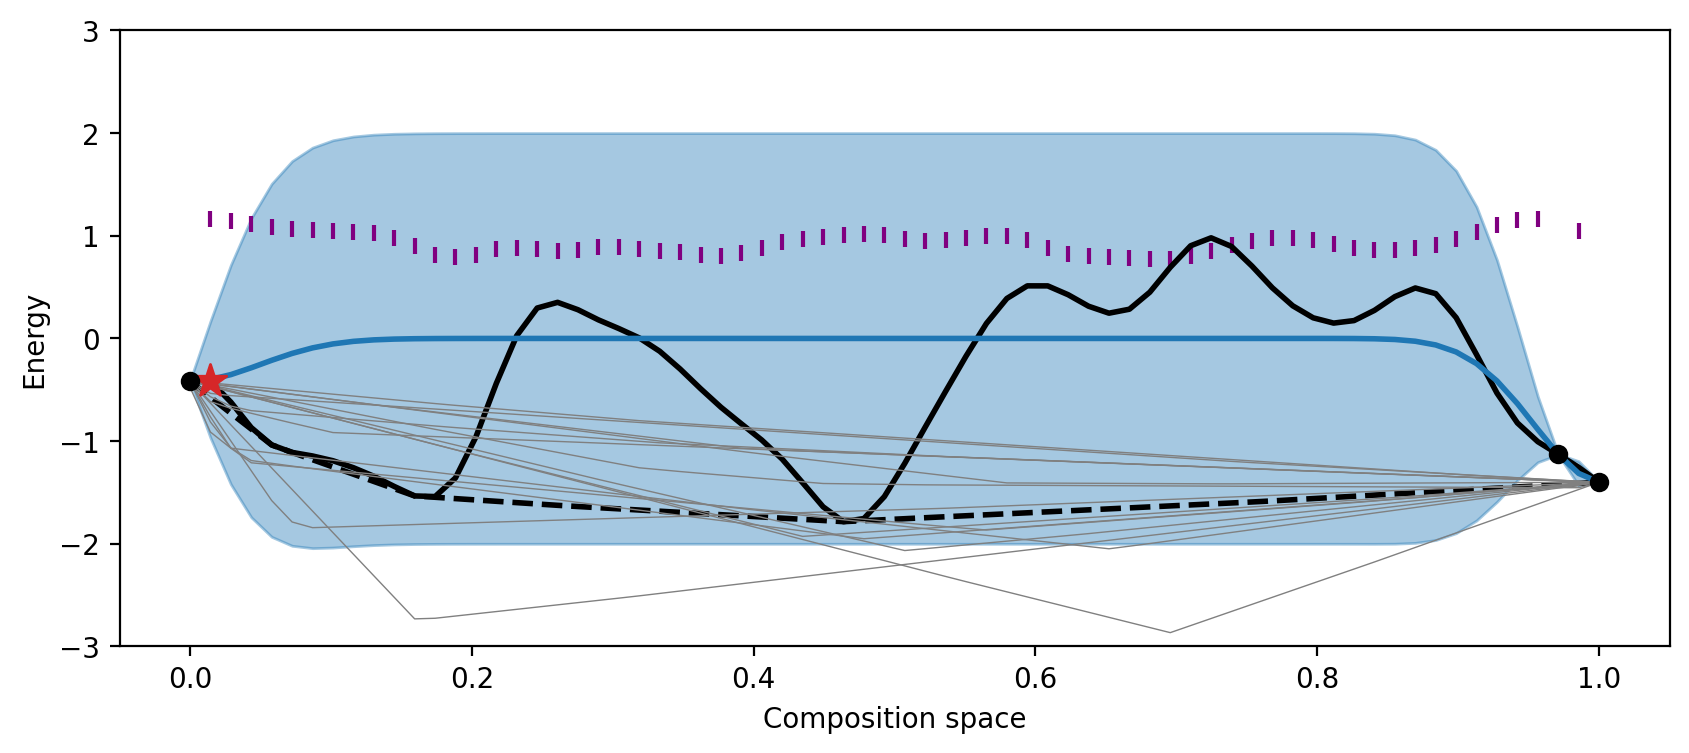

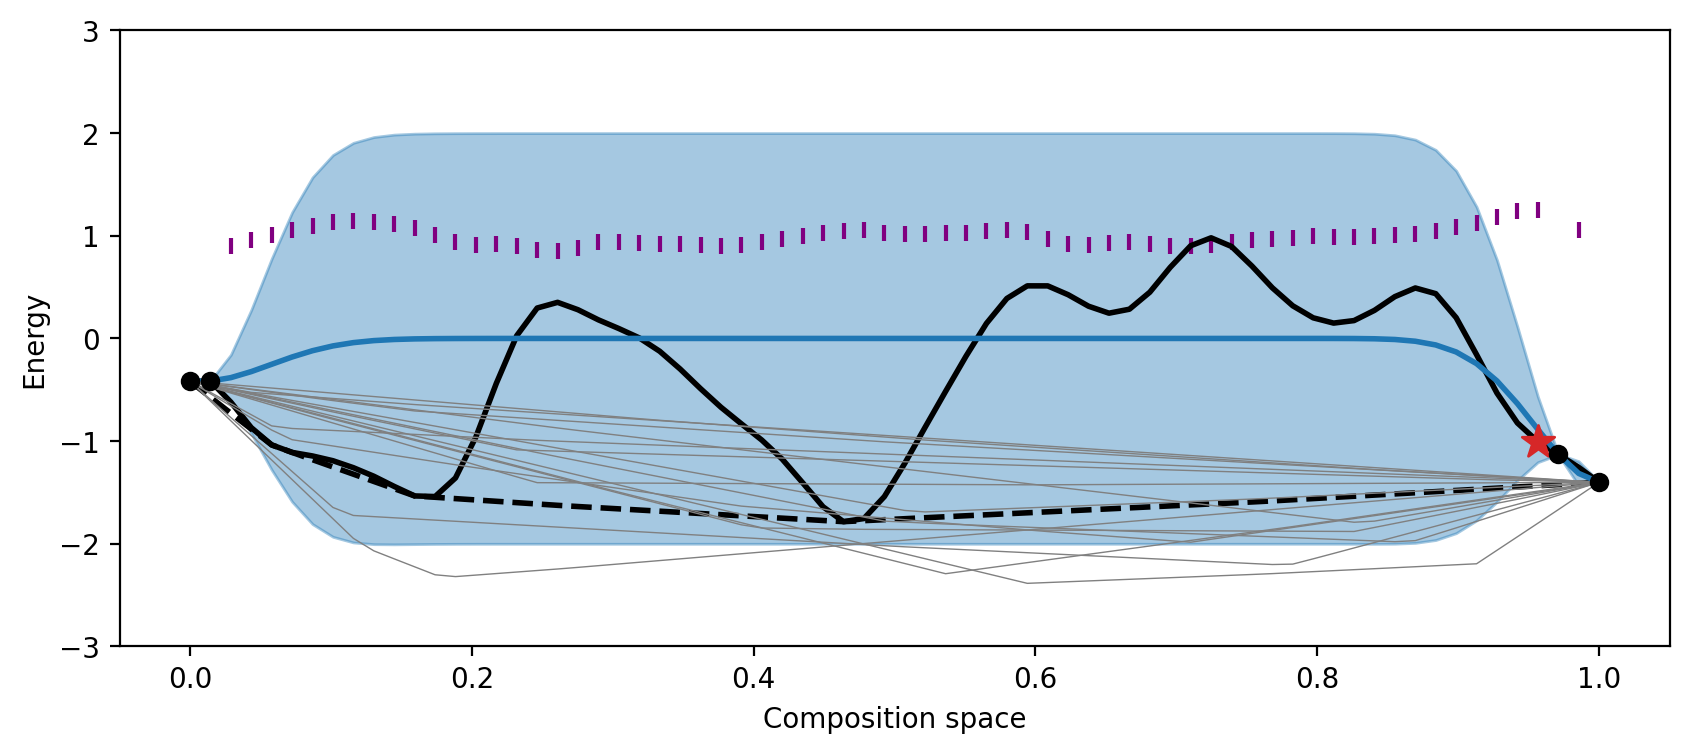

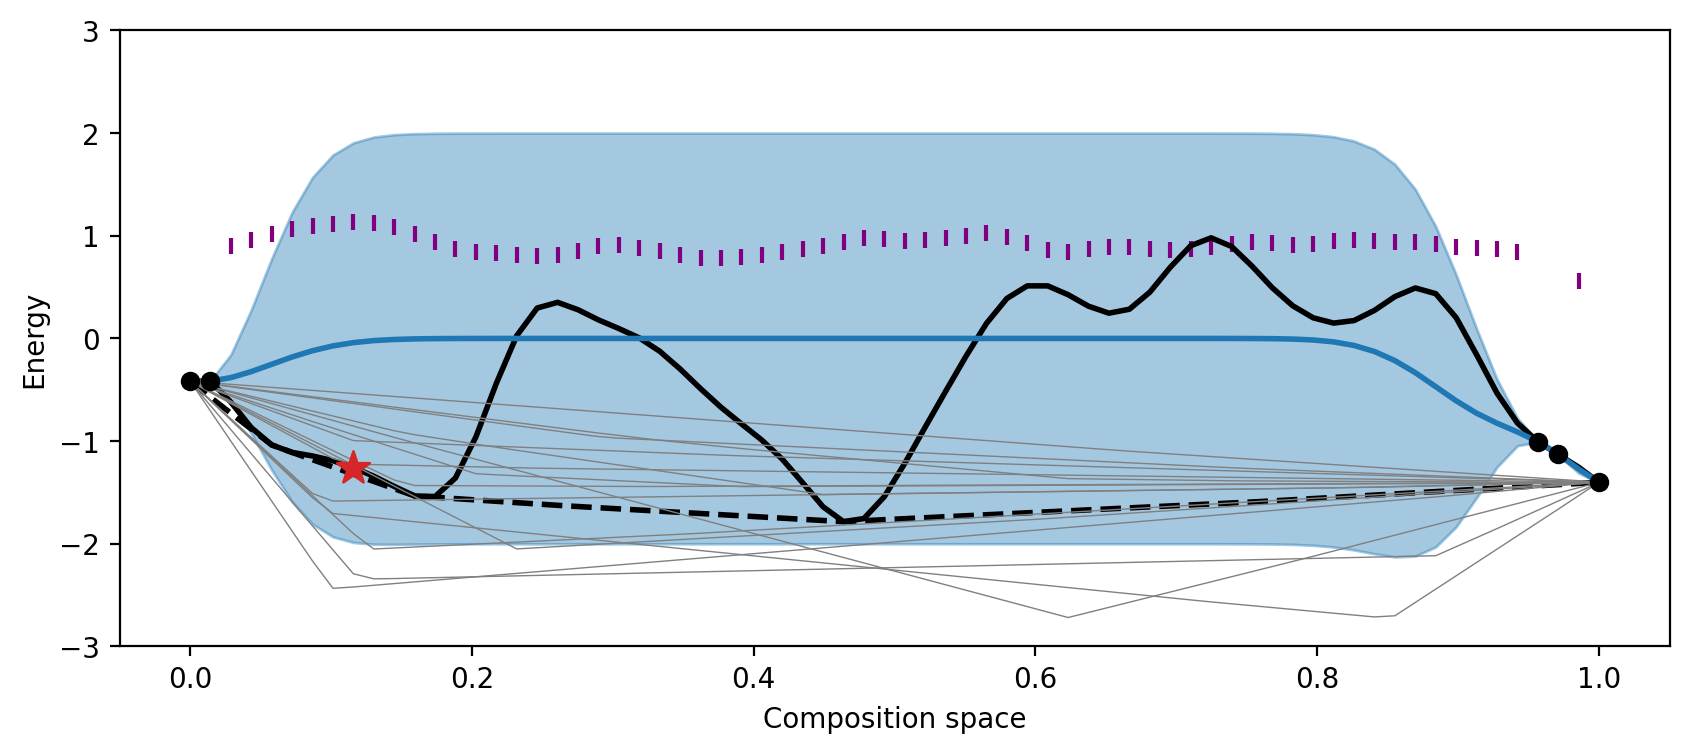

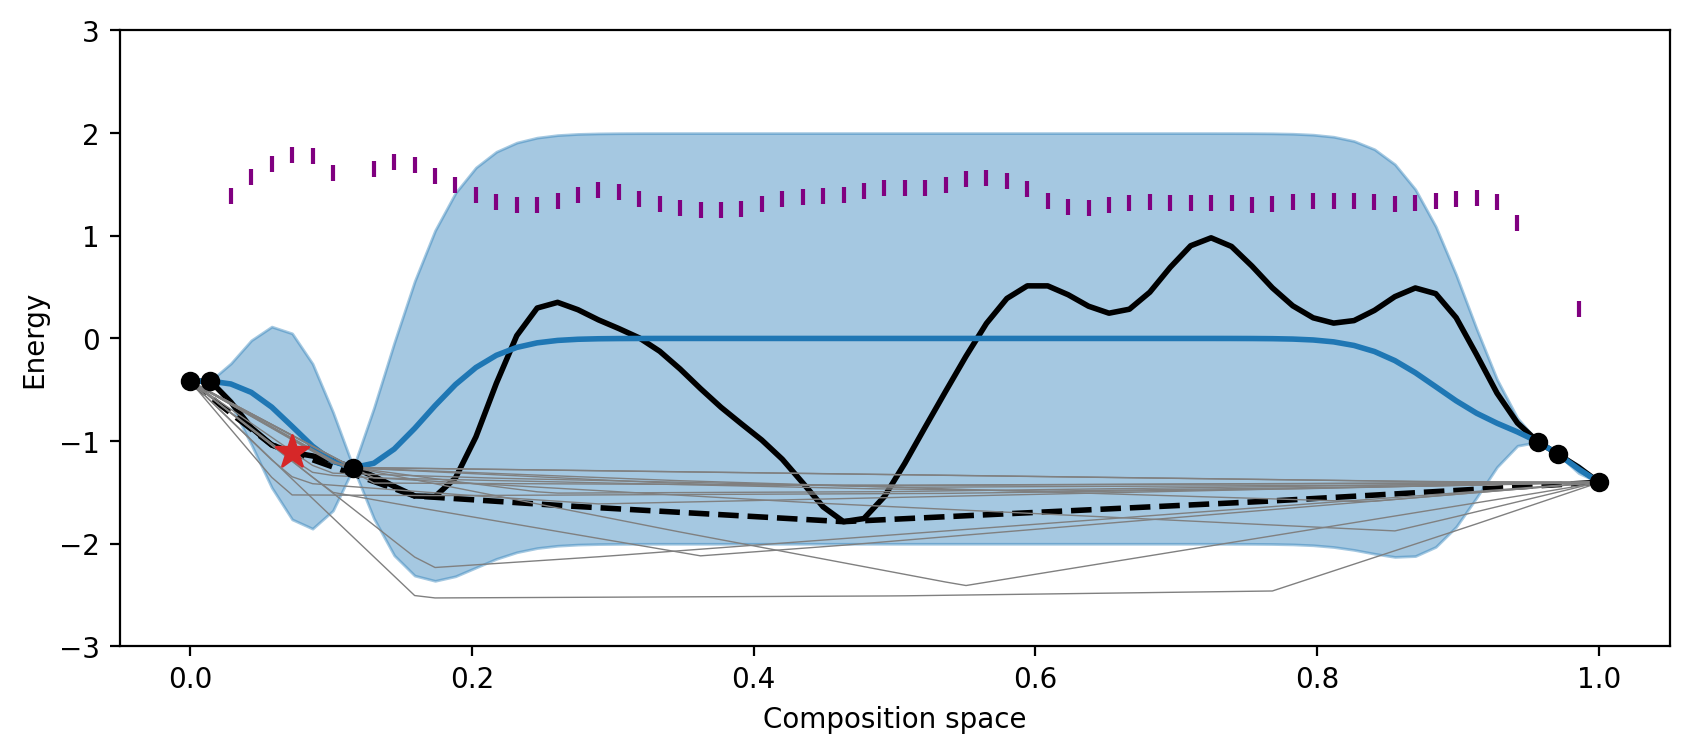

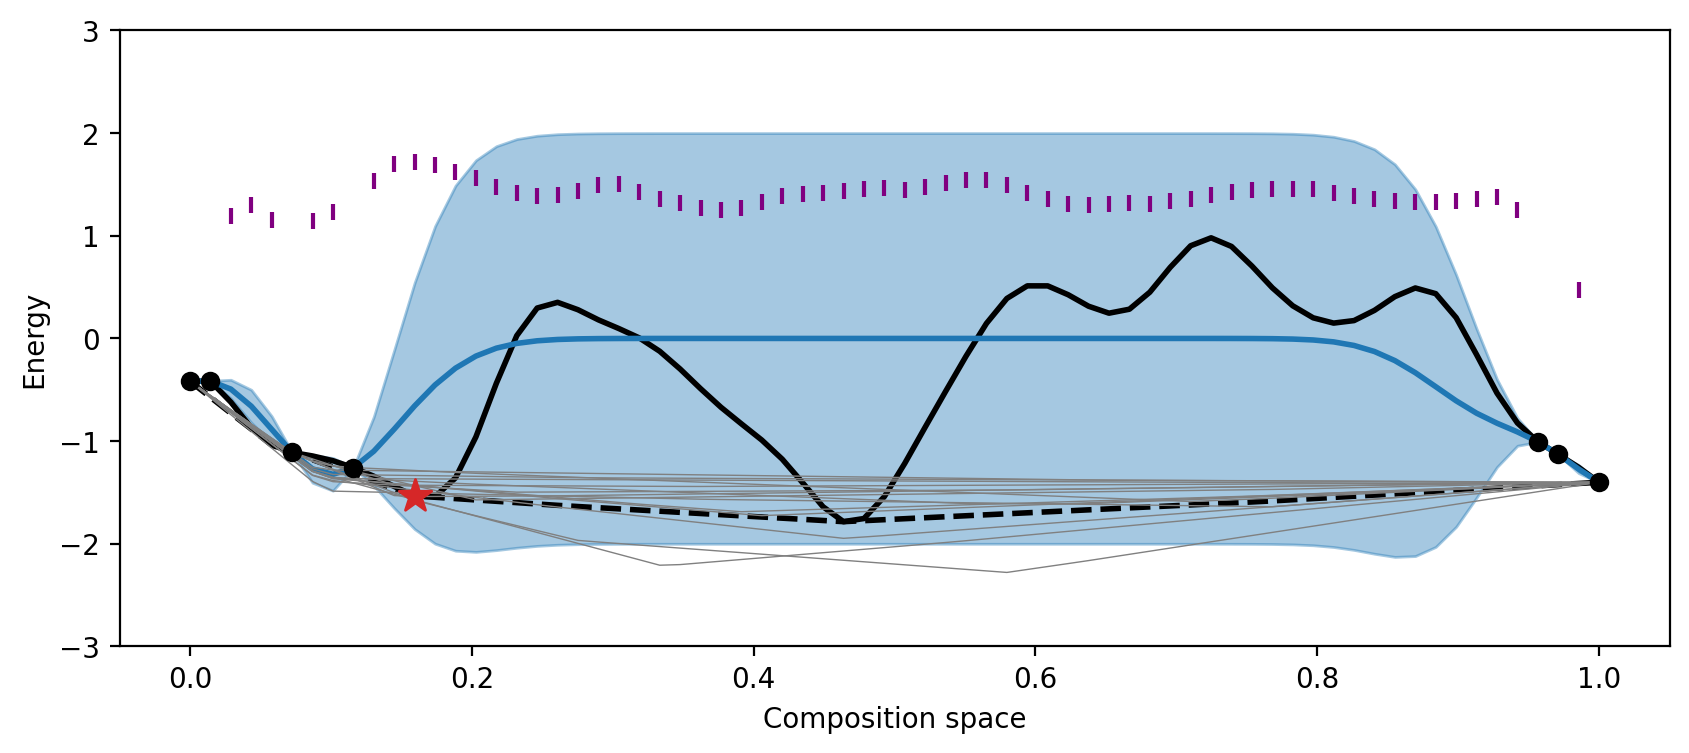

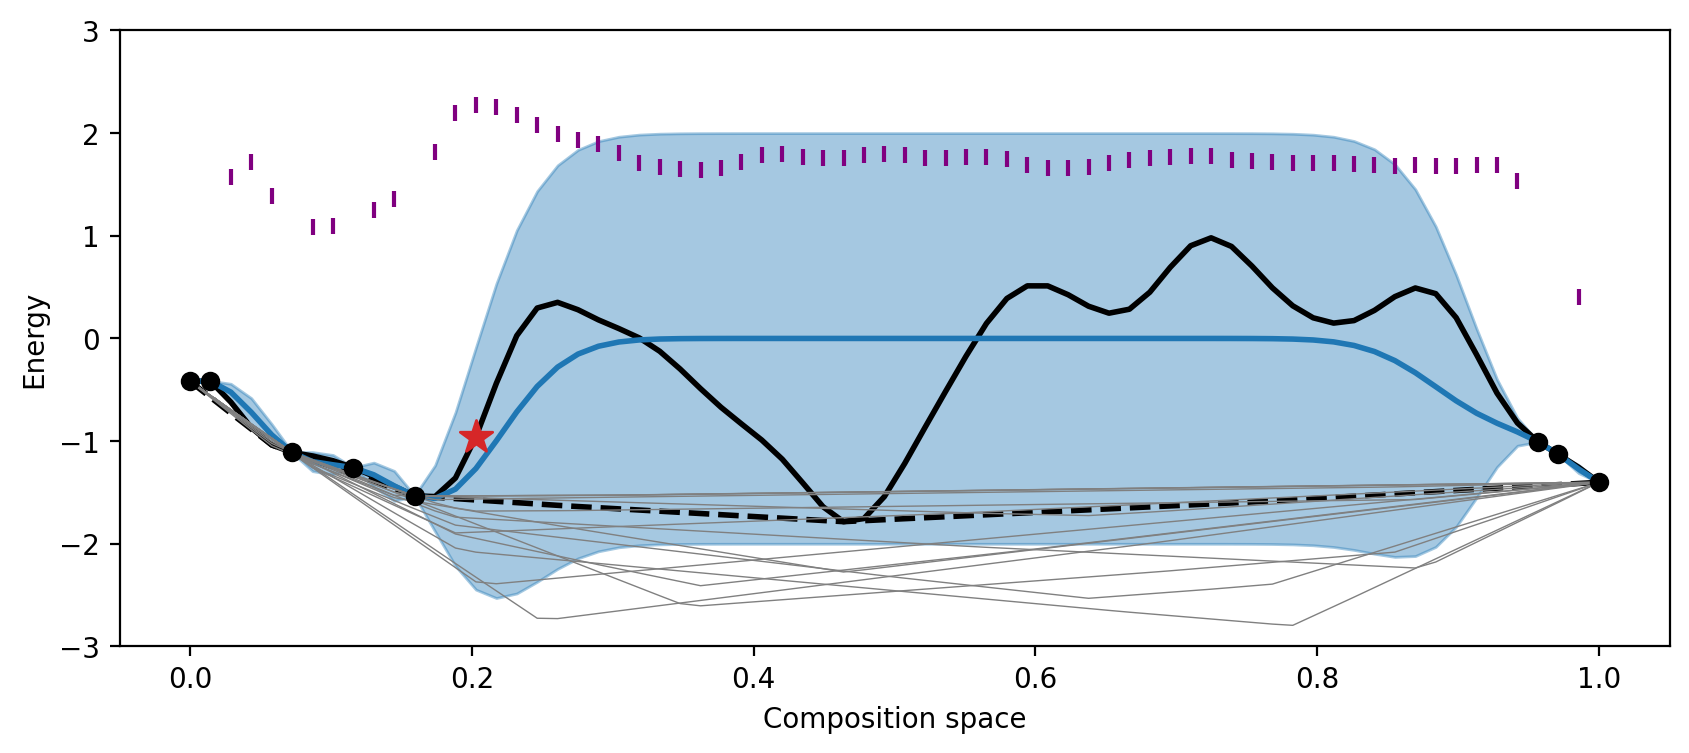

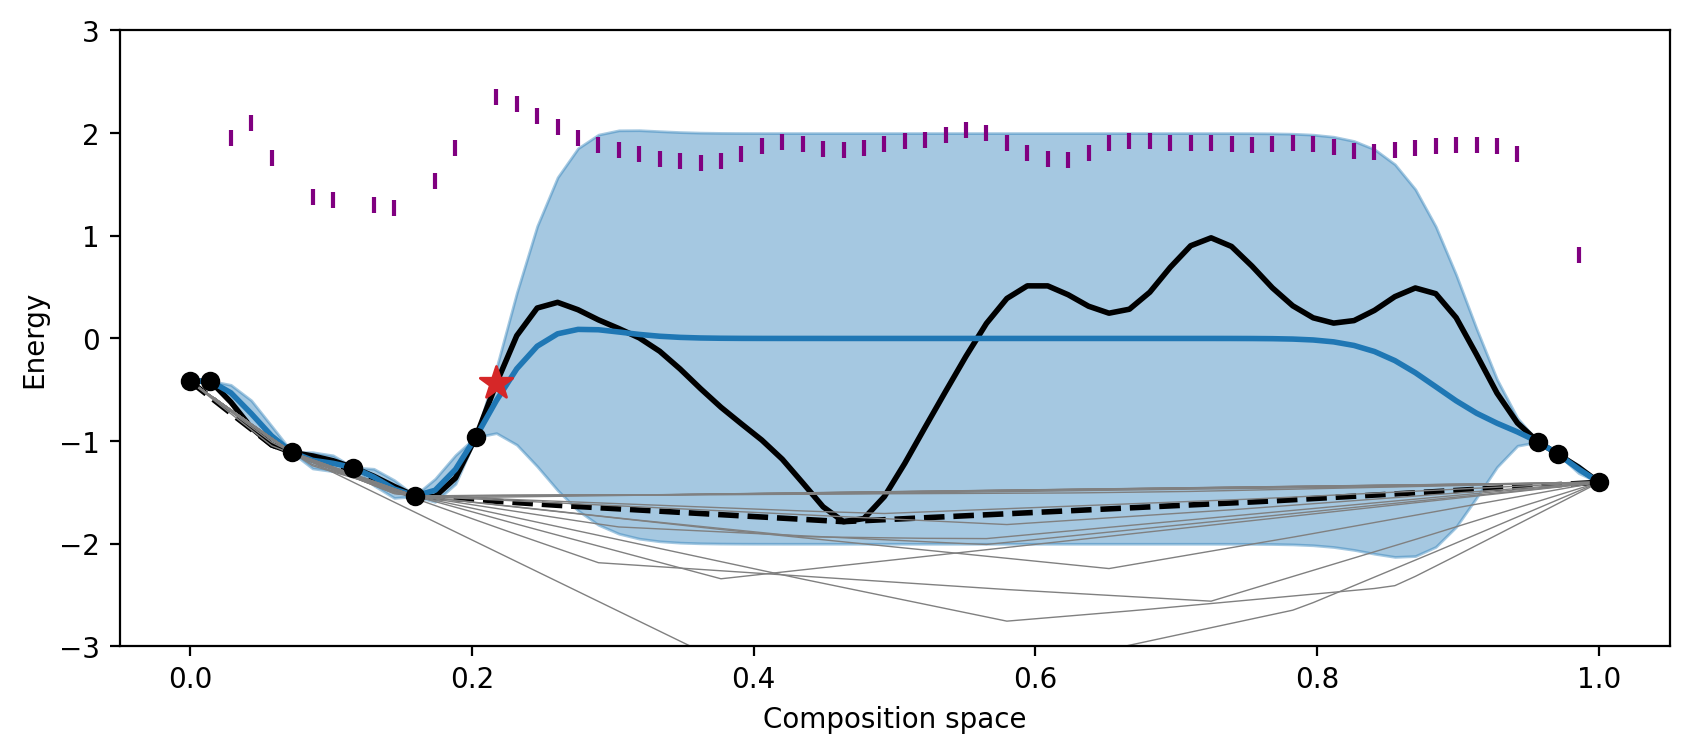

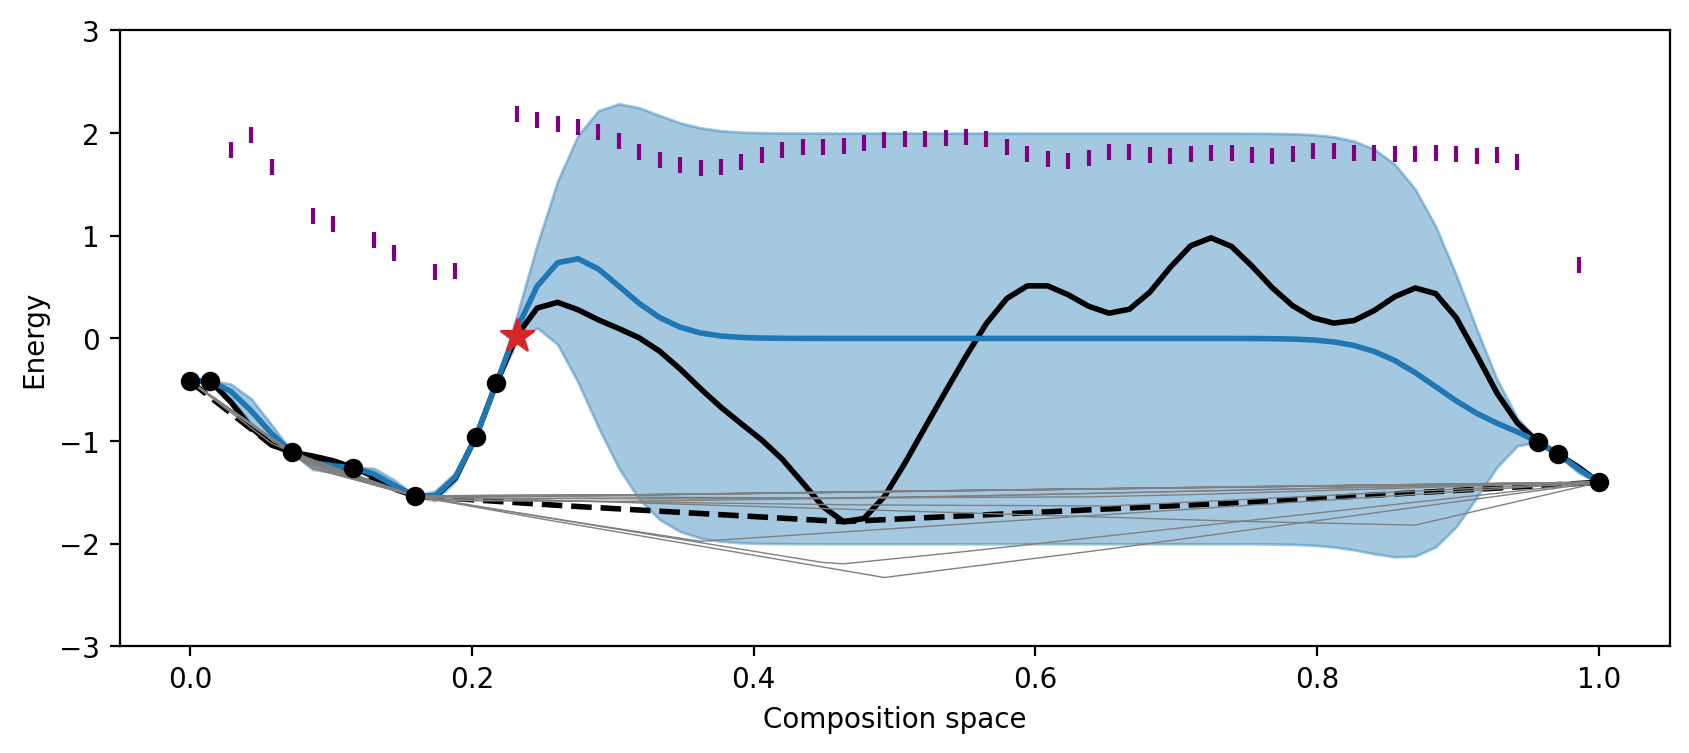

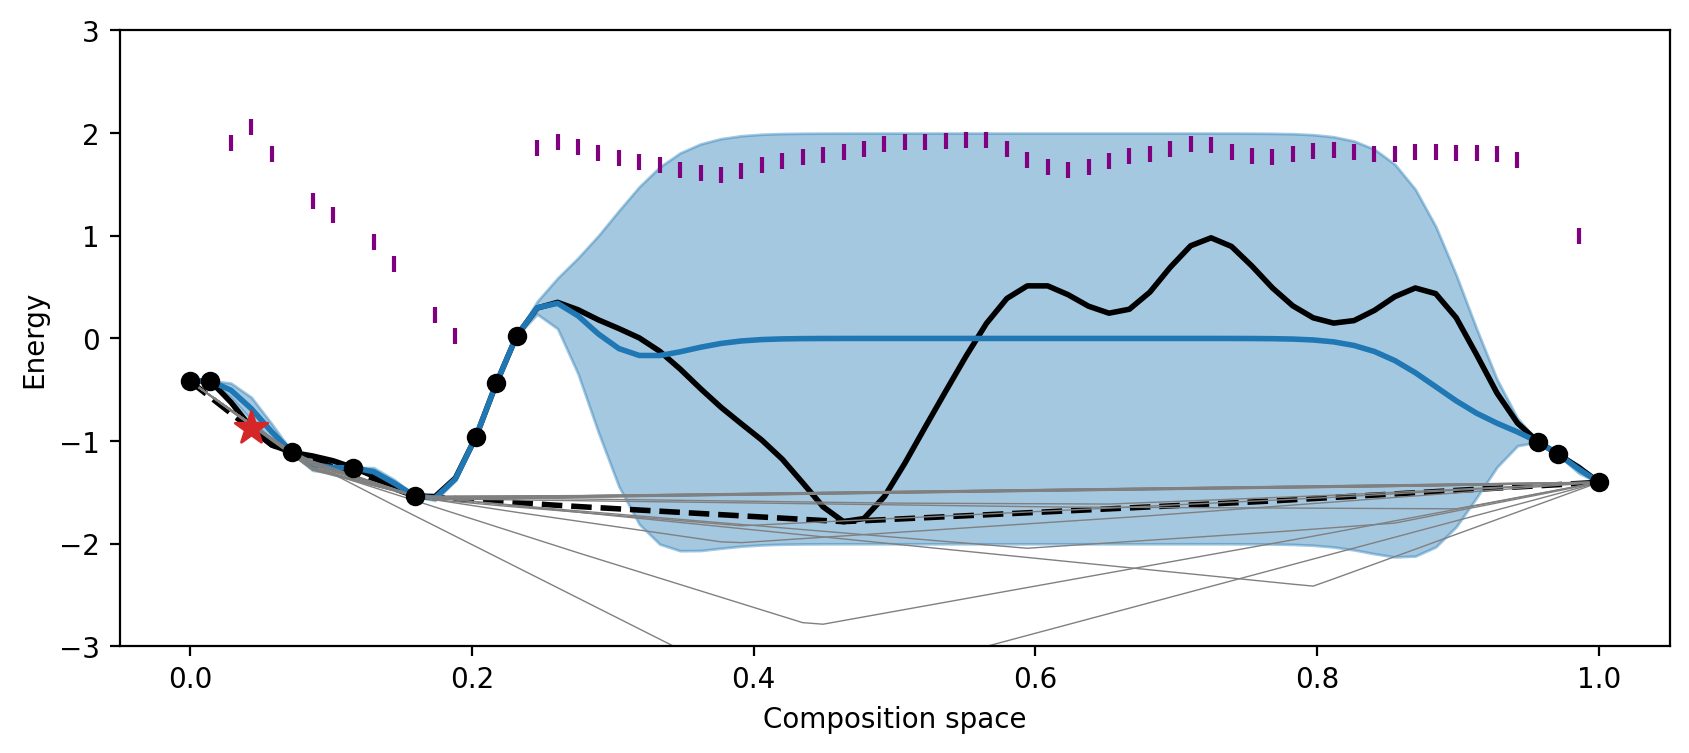

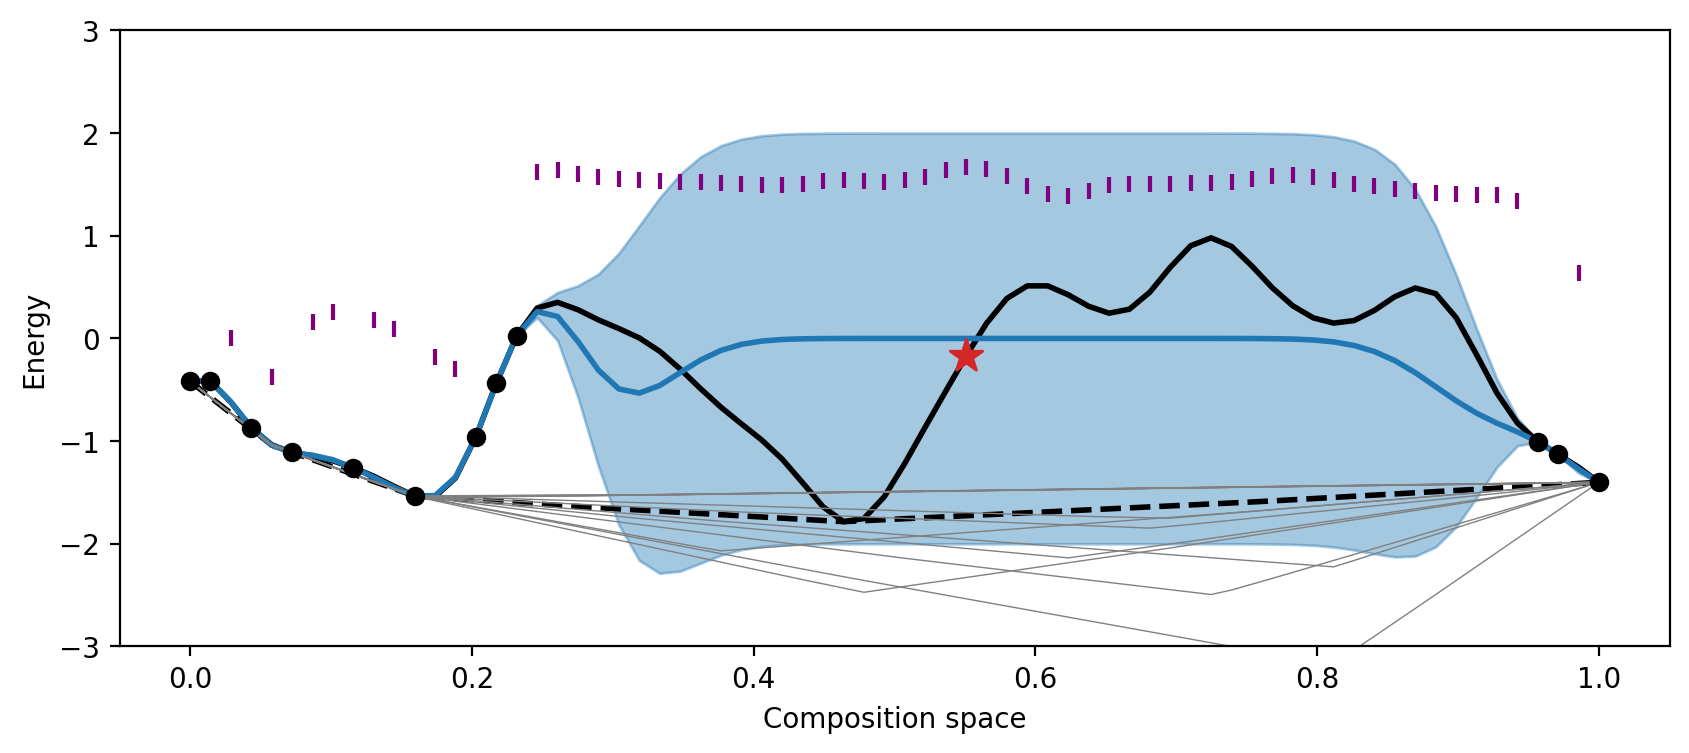

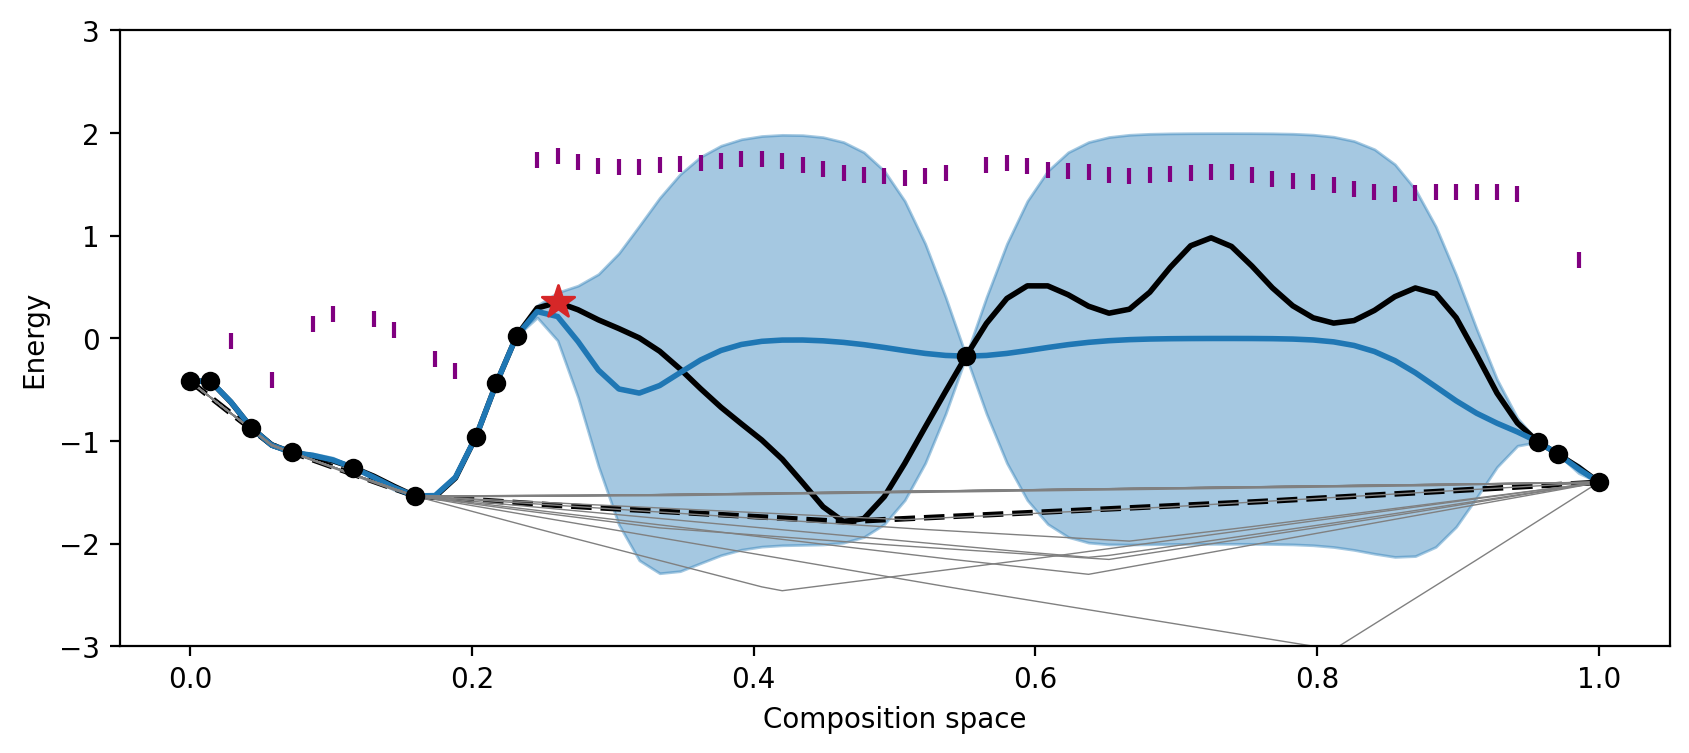

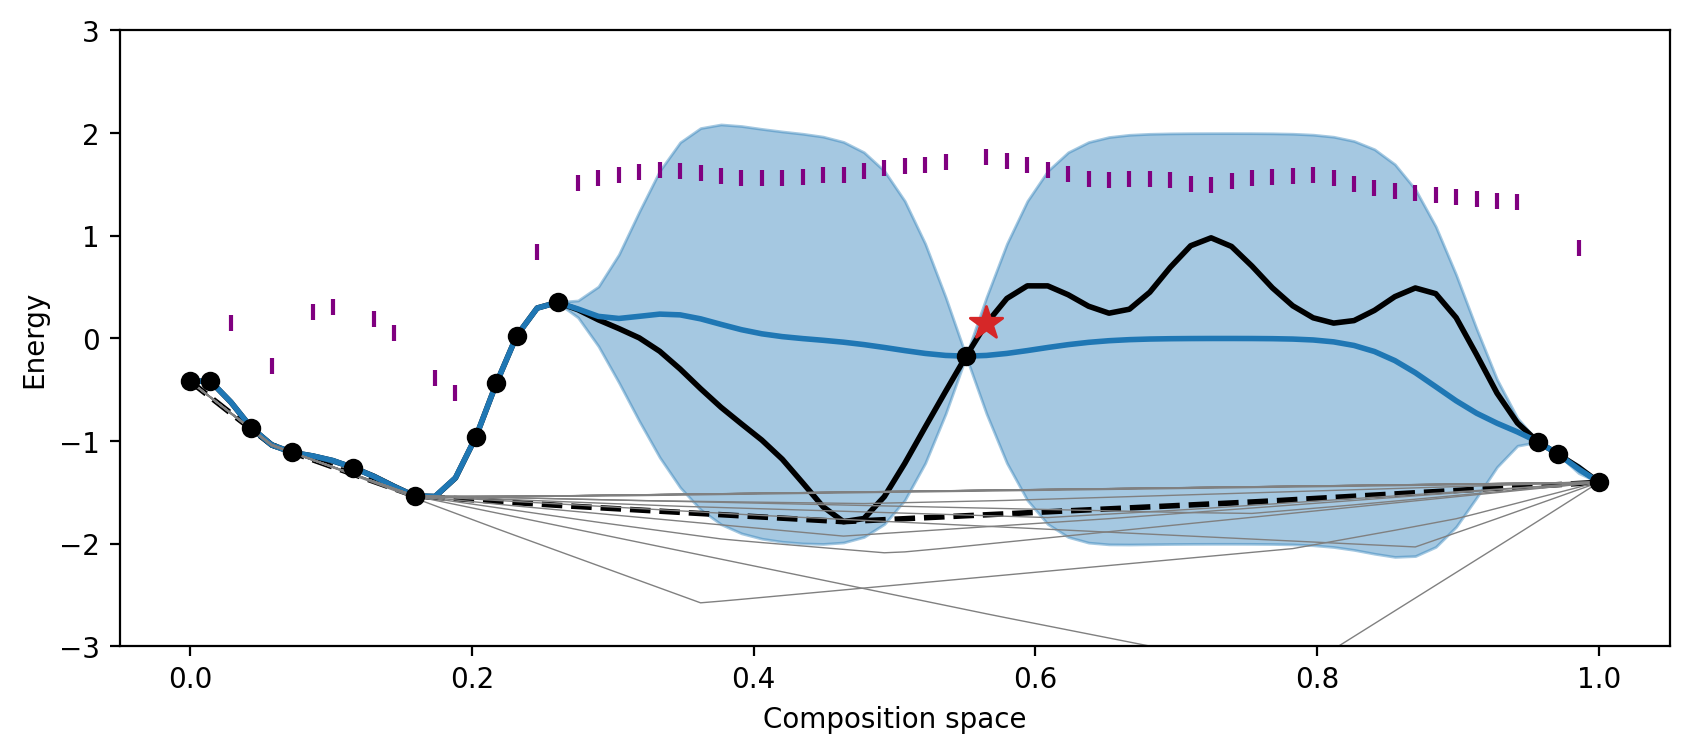

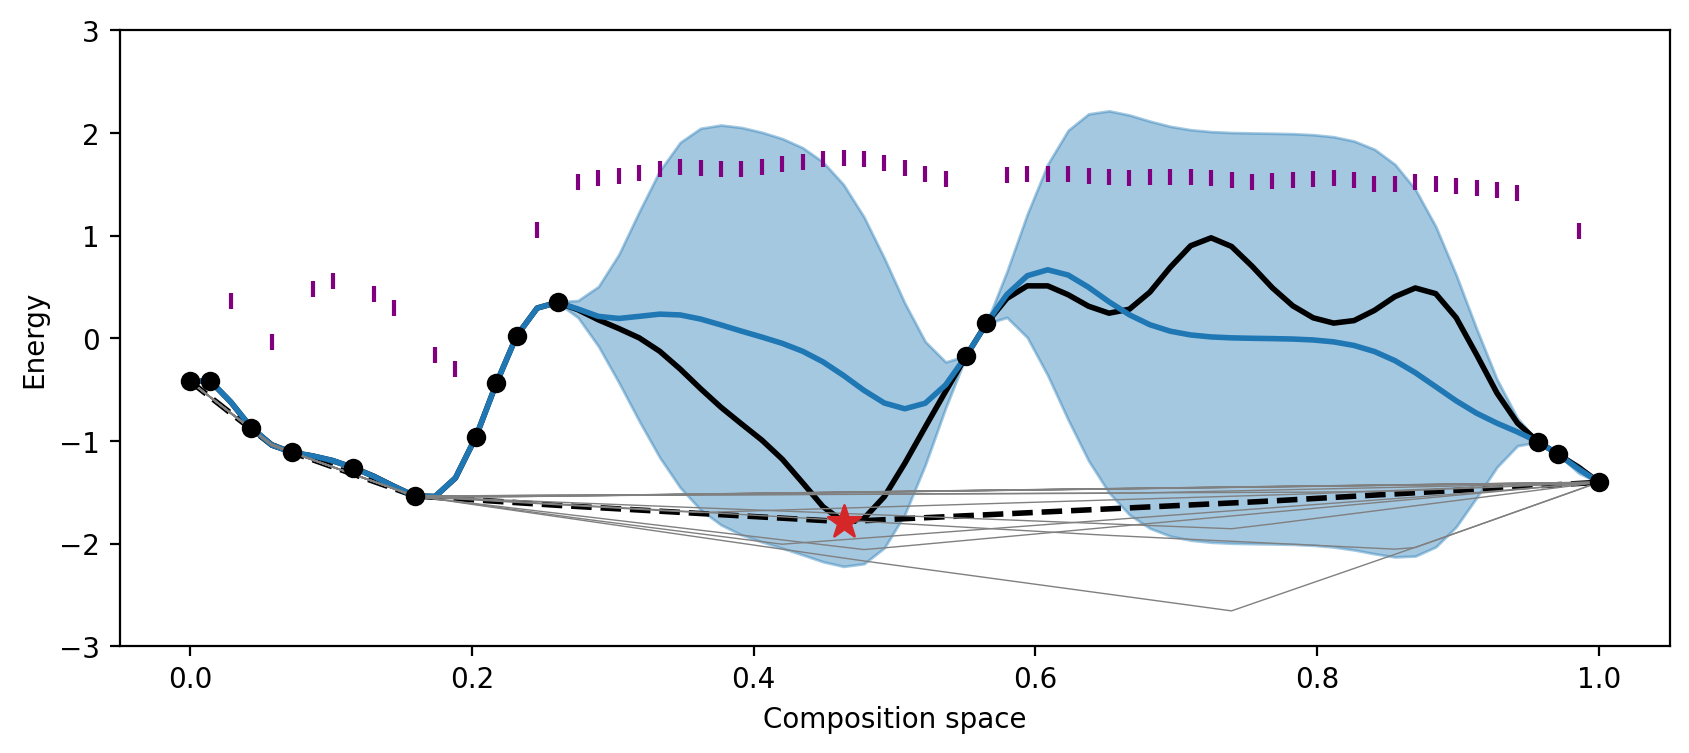

In [4]:
npr.seed(seed); rng_key = jrnd.PRNGKey(seed)

# Suppose we start out by observing the two end points
train_x = jnp.array([design_space[0], design_space[-1]]); train_y = jnp.array([true_y[0], true_y[-1]])
dataset = Dataset(X=train_x, y=train_y[:,jnp.newaxis])
designs = design_space[1:-1]

distances = []; distances.append(compute_distances(dataset, design_space, true_envelope))

# Update the model given the data above
pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)

for i in range(num_iters):
    print("Iteration: ", i)
    
    %time next_x, entropy_change = get_next_candidate(posterior, params, dataset, designs, design_space, rng_key, T=100, J=100)
    print(next_x, entropy_change)
    
    _, envelopes, _ = sample_from_posterior(pred_mean, pred_cov, design_space, 15)
    plot_candidate(knot_x, true_y, true_envelope, pred_mean, pred_cov, envelopes, dataset, next_x, entropy_change, plot_eig=True, plot_hulls=True, designs=designs, legend=False)

    # add observations to data and update list of designs and update model
    dataset = dataset + Dataset(X=jnp.atleast_2d(next_x), y=jnp.atleast_2d(get_next_y(true_y, design_space, next_x)))
    designs = jnp.delete(designs, (designs == next_x).argmax())[:, jnp.newaxis]
    pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)
    distances.append(compute_distances(dataset, design_space, true_envelope))

In [ ]:
"""
npr.seed(seed); rng_key = jrnd.PRNGKey(seed)

# Suppose we start out by observing the two end points
train_x = jnp.array([design_space[0], design_space[-1]]); train_y = jnp.array([true_y[0], true_y[-1]])
dataset = Dataset(X=train_x, y=train_y[:,jnp.newaxis])
designs = design_space[1:-1]

distances = []; distances.append(compute_distances(dataset, design_space, true_envelope))

# Update the model given the data above
pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)

for i in range(num_iters):
    print("Iteration: ", i)
    
    %time next_x, entropy_change = get_next_candidate(posterior, params, dataset, designs, design_space, rng_key, T=200, J=200)
    print(next_x, entropy_change)
    
    _, envelopes, _ = sample_from_posterior(pred_mean, pred_cov, design_space, 15)
    plot_candidate(knot_x, true_y, true_envelope, pred_mean, pred_cov, envelopes, dataset, next_x, entropy_change, plot_eig=True, plot_hulls=True, designs=designs)

    # add observations to data and update list of designs and update model
    dataset = dataset + Dataset(X=jnp.atleast_2d(next_x), y=jnp.atleast_2d(get_next_y(true_y, design_space, next_x)))
    designs = jnp.delete(designs, (designs == next_x).argmax())[:, jnp.newaxis]
    pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)
    distances.append(compute_distances(dataset, design_space, true_envelope))
"""

# Comparison between the two methods

Here we plot the distance of each data point from the true hull by iteration. 
Regions where the plot is flat from iteration to iteration represent stable points; 
small increases represent points that are close to the hull, 
and large increases represent points that are far from the hull.

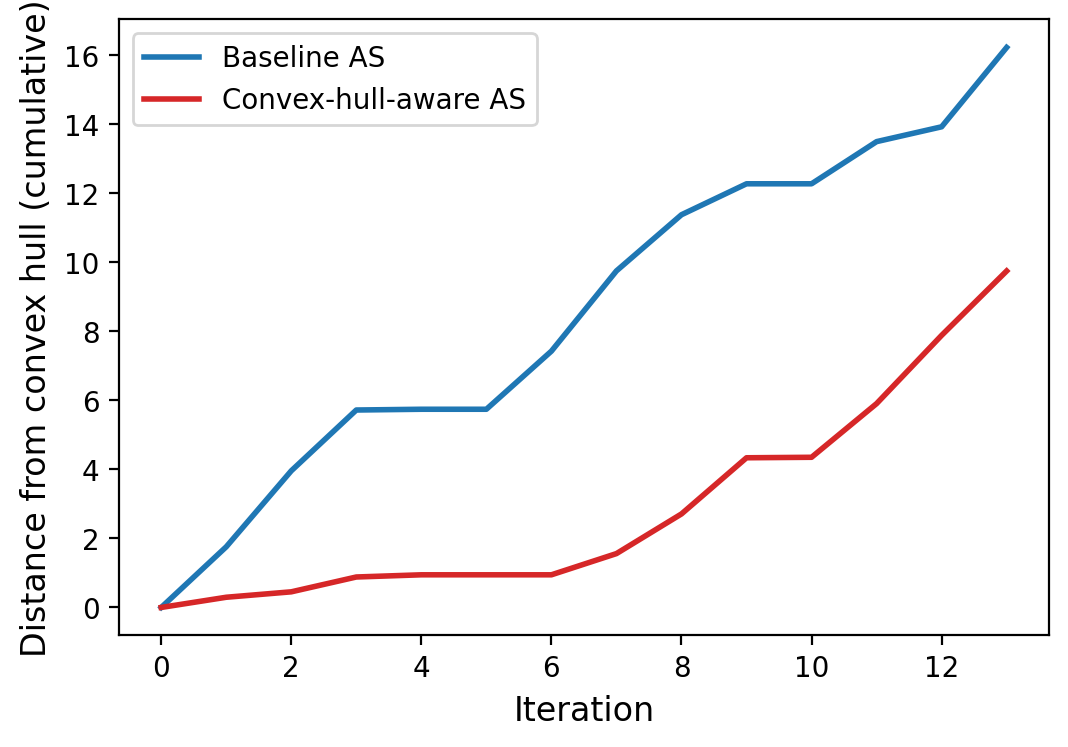

In [6]:
plt.figure(figsize=(6,4)); fs=12; niter=14
c_dist_baseline = [distance.sum() for distance in distances_baseline[0:niter]]
c_dist = [distance.sum() for distance in distances[0:niter]]
                     
plt.plot(c_dist_baseline, label="Baseline AS", lw=2, c="tab:blue")
plt.plot(c_dist, label="Convex-hull-aware AS", lw=2, c="tab:red")

plt.xlabel("Iteration", fontsize=fs); plt.ylabel("Distance from convex hull (cumulative)", fontsize=fs)
plt.legend()
#plt.xlim(-0.9, 12)

In [7]:
n_stable = 2; tol = 1e-2
stables_baseline = [n_stable]
for i in range(len(c_dist_baseline)-1):
    if (c_dist_baseline[i+1] - c_dist_baseline[i]) <= tol:
        n_stable += 1
    stables_baseline.append(n_stable)
    
n_stable = 2
stables = [n_stable]
for i in range(len(c_dist)-1):
    if (c_dist[i+1] - c_dist[i]) <= tol:
        n_stable += 1
    stables.append(n_stable)

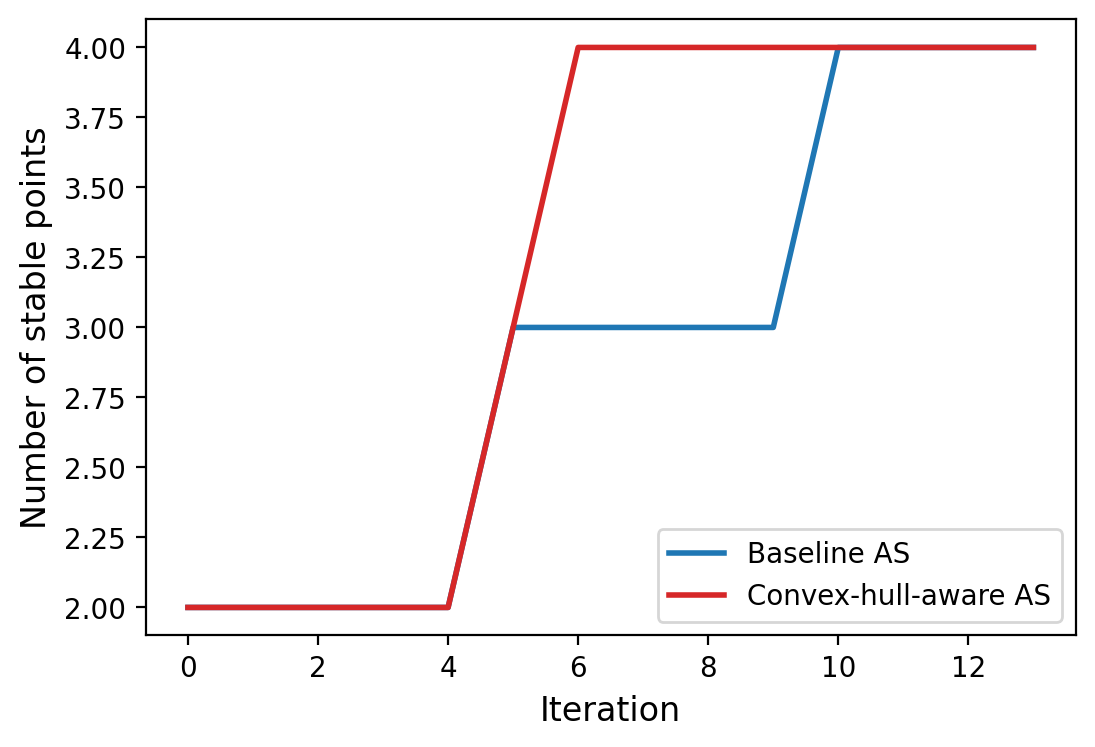

In [8]:
plt.figure(figsize=(6,4)); fs=12
                     
plt.plot(stables_baseline, label="Baseline AS", lw=2, c="tab:blue")
plt.plot(stables, label="Convex-hull-aware AS", lw=2, c="tab:red")

plt.xlabel("Iteration", fontsize=fs); plt.ylabel("Number of stable points", fontsize=fs)
plt.legend()